## PROJECT: COMPREHENSIVE E-COMMERCE SALES AND USER BEHAVIOR ANALYSIS

## Introduction and Project Goals

This project provides an in-depth analysis of e-commerce data sourced from Google BigQuery, focusing on identifying key factors influencing sales and user behavior. The primary goal of this analysis is to provide data-driven insights for optimizing marketing strategies and enhancing overall business effectiveness.

**Key objectives addressed within the project:**

* **Data Integration and Preparation:** Creation of a unified dataset by combining various BigQuery sources, including information on orders, sessions, users, devices, and traffic sources.
* **Descriptive Analysis:** Characterizing the structure and attributes of the resulting dataset, identifying missing values, and outlining general metrics.
* **Analysis of Key Sales and Traffic Metrics:** Determining the most profitable continents, countries, product categories, and traffic channels.
* **Trend Analysis:** Investigating sales seasonality and trends across geographical regions, traffic channels, and device types.
* **Relationship Identification:** Statistical analysis of correlations between key performance indicators (e.g., sessions and sales).
* **Group Comparisons:** Statistical analysis of differences in behavior and sales among various user segments (e.g., registered vs. unregistered, users from different devices/channels).
* **Data Visualization:** Developing an interactive dashboard in Tableau Public to present key insights.

**Tools Used:** SQL, Python (Pandas, NumPy, SciPy, Matplotlib, Seaborn), Google BigQuery, Tableau Public.







# **1. CONNECTING TO BIGQUERY AND RETRIEVING THE DATASET**

The data for analysis was retrieved directly from Google BigQuery cloud storage using an SQL query.

In [84]:
# Installing and upgrading required Python libraries

!pip install --upgrade google-cloud-bigquery pandas

In [2]:
# Importing required Python libraries for data analysis and visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Importing specific modules for statistics and Google Cloud access

from google.cloud import bigquery
from google.colab import auth
from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal


# Authenticating Google Cloud access in Google Colab

auth.authenticate_user()




In [3]:
# Initializing the BigQuery Client and Executing a SQL Query
# To enable further statistical analysis, we add a column with all session dates

client = bigquery.Client(project='data-analytics-mate')
query = """
SELECT
  CASE
    WHEN p.name IS NULL OR TRIM(p.name) = '' THEN NULL
    ELSE s.date
  END AS order_date,
  s.ga_session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language AS browser_language,
  sp.name AS traffic_source,
  sp.channel,
  acc.id AS account_id,
  acc.is_verified,
  acc.is_unsubscribed,
  p.category AS product_category,
  p.name AS product_name,
  p.price,
  p.short_description,
  s.date as session_date
FROM `data-analytics-mate.DA.session` s
JOIN `data-analytics-mate.DA.session_params` sp
ON s.ga_session_id = sp.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account_session` acs
ON s.ga_session_id = acs.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account` acc
ON acs.account_id = acc.id
LEFT JOIN `data-analytics-mate.DA.order` o
ON s.ga_session_id = o.ga_session_id
LEFT JOIN `data-analytics-mate.DA.product`
p ON o.item_id = p.item_id
"""

In [4]:
# Run the query using BigQuery client and convert the result to a pandas DataFrame

df = client.query(query).to_dataframe()

# **2. OVERVIEW OF THE OBTAINED DATASET, NORMALIZATION AND DATA CLEANING**

In this section, initial data preprocessing was performed, including:

*  stripping extra whitespace from text columns,





*  normalizing text case,

*  converting variable types to analysis-friendly formats,

*  checking for and handling duplicates,

*  conducting a preliminary assessment of qualitative and quantitative features.

In [5]:
# dataset overview

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         33538 non-null   dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   browser_language   235279 non-null  object 
 9   traffic_source     349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  product_category   33538 non-null   object 
 15  product_name       33538 non-null   object 
 16  pr

,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,browser_language,traffic_source,channel,account_id,is_verified,is_unsubscribed,product_category,product_name,price,short_description,session_date
0,NaT,7268004754,(not set),(not set),desktop,Chrome,Chrome,Web,en-gb,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None,2021-01-19
1,NaT,8321293308,(not set),(not set),desktop,Chrome,Chrome,Web,None,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None,2021-01-06
2,NaT,4392362373,(not set),(not set),desktop,Chrome,Chrome,Web,None,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None,2020-11-05
3,NaT,140108698,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None,2020-12-09
4,NaT,8351127264,(not set),(not set),mobile,Safari,iPhone,Web,en-us,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None,2020-11-10


Dataset contains **19** columns and **349545** rows.

**Data structure:**



| Data type | Count | Description |
|-----------|:---------:|------------------|
| dbdate    | 2         |  Order_date and session_date (requires conversion from dbdate format)         |
| int64     | 4         | Integer values (e.g. account_id, ga_session_id, is_unsubscribed, is_verified)|
| object    | 12        | text and categorical data |
| float64   | 1         | floating-point numeric data|


**Recommended data transformation:**

Columns with dbdate format → to convert to a standard datetime format for proper handling with pandas


It is worth noting that the browser_language column contains null values, which should be replaced with "Unknown" to ensure consistency



In [6]:
# replacing null values in the 'browser_language' column

df['browser_language'] = df['browser_language'].fillna('unknown')

# checking columns with data type 'object' for extra spaces, unique values

columns_to_normalize = [
    'continent',
    'country',
    'device',
    'browser',
    'mobile_model_name',
    'operating_system',
    'browser_language',
    'traffic_source',
    'channel',
    'product_category'
]


def strip_whitespace_from_text_columns(df):
    for column in df.select_dtypes(include='object').columns:
        df[column] = df[column].str.strip()
        if column in columns_to_normalize:
          df[column] = df[column].str.lower()
        print(f"\nCount of unique values in '{column}':  {len(df[column].unique())}")
        if len(df[column].unique()) <= 10:
          unique_values = pd.Series(df[column].dropna().unique()).str.title()
          print(f"Unique values in '{column}': {sorted(unique_values)}")
    return df
df_cleaned = strip_whitespace_from_text_columns(df.copy())
unique_countries = pd.Series(df_cleaned['country'].unique()).str.title()
print(f"\nList of countries ({len(unique_countries)} total): {sorted(unique_countries)}")
count_of_duplicates = df_cleaned.duplicated().sum()
print(f"\nCount of duplicates {count_of_duplicates}")
if count_of_duplicates > 0:
  df_cleaned = df_cleaned.drop_duplicates()
  print(f'\nДублікати видалені')



Count of unique values in 'continent':  6
Unique values in 'continent': ['(Not Set)', 'Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

Count of unique values in 'country':  108

Count of unique values in 'device':  3
Unique values in 'device': ['Desktop', 'Mobile', 'Tablet']

Count of unique values in 'browser':  6
Unique values in 'browser': ['<Other>', 'Android Webview', 'Chrome', 'Edge', 'Firefox', 'Safari']

Count of unique values in 'mobile_model_name':  10
Unique values in 'mobile_model_name': ['<Other>', 'Chrome', 'Chromebook', 'Edge', 'Firefox', 'Ipad', 'Iphone', 'Pixel 3', 'Pixel 4 Xl', 'Safari']

Count of unique values in 'operating_system':  6
Unique values in 'operating_system': ['<Other>', 'Android', 'Ios', 'Macintosh', 'Web', 'Windows']

Count of unique values in 'browser_language':  10
Unique values in 'browser_language': ['De', 'En', 'En-Ca', 'En-Gb', 'En-Us', 'Es-Es', 'Fr', 'Ko', 'Unknown', 'Zh']

Count of unique values in 'traffic_source':  5
Unique values in 'tra

In [7]:
# Convert the 'order_date' and 'session_date" column to datetime format

df_cleaned["order_date"] = pd.to_datetime(df_cleaned["order_date"], format= "%Y-%m-%d")
df_cleaned["session_date"] = pd.to_datetime(df_cleaned["session_date"], format= "%Y-%m-%d")

# Defining the date interval in the dataset

print(f"Date_range: from {df_cleaned['session_date'].min().date()} to {df_cleaned['session_date'].max().date()}\n")
print(f"Date_range for sessions with order is: from {df_cleaned['order_date'].min().date()} to {df_cleaned['order_date'].max().date()}\n")
df_cleaned.head()
df_cleaned.info()

# Values in selected columns were converted to title case

for column in columns_to_normalize:
    df_cleaned[column] = df_cleaned[column].str.title()

Date_range: from 2020-11-01 to 2021-01-31

Date_range for sessions with order is: from 2020-11-01 to 2021-01-27

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_date         33538 non-null   datetime64[ns]
 1   ga_session_id      349545 non-null  Int64         
 2   continent          349545 non-null  object        
 3   country            349545 non-null  object        
 4   device             349545 non-null  object        
 5   browser            349545 non-null  object        
 6   mobile_model_name  349545 non-null  object        
 7   operating_system   349545 non-null  object        
 8   browser_language   349545 non-null  object        
 9   traffic_source     349545 non-null  object        
 10  channel            349545 non-null  object        
 11  account_id         27945 non-null   Int64  

In [8]:
# counting the number of unique sessions

print(f"Count of unique sessions: {len(df_cleaned['ga_session_id'].unique())}")

# counting the number of unique account_id

print(f"Count of unique accounts: {len(df_cleaned['account_id'].unique())}")


Count of unique sessions: 349545
Count of unique accounts: 27946


In [9]:
# Count the number of missing (NaN) values in each column of the cleaned dataset

df_cleaned.isna().sum()

,0
order_date,316007
ga_session_id,0
continent,0
country,0
device,0
browser,0
mobile_model_name,0
operating_system,0
browser_language,0
traffic_source,0


**Summary:**

**- Data cleaning**

Extra spaces in text columns were removed.

None values in the browser_language column were replaced with "Unknown".



**- Case normalization:**

Values in selected columns were converted to lowercase (lower()), and then restored to title case (title()) for visualization purposes.



**- Columns to normalize:**

* continent
* device

* browser

* mobile_model_name

* operating_system

* browser_language

* traffic_source

* channel

* product_category


**- Data Type conversion**

"order_date"  was converted to datetime64

**Duplicates check:**

Duplicates: 0, cleaning is not required


**- Date interval:**

from **2020-11-01** to **2021-01-31**

**Date interval for session with order:**

from **2020-11-01** to **2021-01-27**

| Column             | Number of unique values  |
|---------------------|-------------------------------|
| continent           | 6                             |
| country             | 108                           |
| device              | 3                             |
| browser             | 6                             |
| mobile_model_name   | 10                            |
| operating_system    | 6                             |
| browser_language    | 10                            |
| traffic_source      | 5                             |
| channel             | 5                             |
| product_category    | 15                            |
| product_name        | 551                           |
| short_description   | 1477                          |

**Number of unique session and accounts:**

* Unique ga_session_id: `349 545`

* Unique account_id: `27 946`



**- Missing Values:**

Detected in the following columns:

* order_date, product_category, product_name, short_description — missing in rows without completed orders (which is expected, as not every session results in a purchase).

* account_id, is_verified, is_unsubscribed — missing in cases where the user made a purchase without registering an account.

These missing values are consistent with the business logic and reflect typical user behavior on the website.





# **3. KEY SALES AND USER METRICS ANALYSIS**

## 3.1. Key Total Metrics

In [10]:
# Creating revenue dataset for analysis (filtering rows with orders)

df_sales = df_cleaned[df_cleaned['order_date'].notna()].copy()
df_sales.info()
df_sales.head()

<class 'pandas.core.frame.DataFrame'>
Index: 33538 entries, 12 to 349509
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_date         33538 non-null  datetime64[ns]
 1   ga_session_id      33538 non-null  Int64         
 2   continent          33538 non-null  object        
 3   country            33538 non-null  object        
 4   device             33538 non-null  object        
 5   browser            33538 non-null  object        
 6   mobile_model_name  33538 non-null  object        
 7   operating_system   33538 non-null  object        
 8   browser_language   33538 non-null  object        
 9   traffic_source     33538 non-null  object        
 10  channel            33538 non-null  object        
 11  account_id         2781 non-null   Int64         
 12  is_verified        2781 non-null   Int64         
 13  is_unsubscribed    2781 non-null   Int64         
 14  product_c

,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,browser_language,traffic_source,channel,account_id,is_verified,is_unsubscribed,product_category,product_name,price,short_description,session_date
12,2020-12-24,5726438444,(Not Set),(Not Set),Desktop,Chrome,Chrome,Web,Unknown,(Referral),Paid Search,<NA>,<NA>,<NA>,Cabinets & Cupboards,LIXHULT,356.0,"Wall-mounted cabinet combination, 50x25x50 cm",2020-12-24
28,2020-12-13,5614986004,(Not Set),(Not Set),Desktop,<Other>,<Other>,Web,En-Ca,(Organic),Organic Search,<NA>,<NA>,<NA>,Tables & Desks,BEKANT,1325.0,"Desk, 140x60 cm",2020-12-13
39,2020-11-05,8542454082,(Not Set),(Not Set),Desktop,Chrome,Safari,Web,En-Us,(Data Deleted),Undefined,<NA>,<NA>,<NA>,Chairs,ANTILOP,20.0,Cover,2020-11-05
41,2020-12-16,1717992506,(Not Set),(Not Set),Mobile,Safari,Iphone,Web,En-Us,(Data Deleted),Undefined,<NA>,<NA>,<NA>,Beds,SUNDVIK,849.0,"Ext bed frame with slatted bed base, 80x200 cm",2020-12-16
55,2021-01-16,8416141289,(Not Set),(Not Set),Desktop,Chrome,Safari,Web,En-Gb,(Direct),Direct,<NA>,<NA>,<NA>,Bookcases & Shelving Units,ALGOT,130.0,"Wall upright/drying rack, 66x41x197 cm",2021-01-16


In [11]:
# Total sales analysis

total_revenue = df_sales['price'].sum()
print(f'\nTotal revenue: {total_revenue} $')

total_count_of_order = df_sales["ga_session_id"].nunique()
print(f'\nTotal count of orders: {total_count_of_order}')

total_sales_avg = (total_revenue / total_count_of_order)
print(f"\nAverage revenue per order: {total_sales_avg:.2f} $")

# Check if there are orders with multiple

if len(df_sales) > total_count_of_order:
   print("\nThere are orders with multiple positions")
   order_items_count = df_sales.groupby('ga_session_id').size().reset_index(name='item_count')
   orders_with_multiple_items = order_items_count[order_items_count['item_count'] > 1]
   count_of_orders_with_multiple_items = len(orders_with_multiple_items)
else:
  print("\nEach order has one position")


Total revenue: 31971731.1 $

Total count of orders: 33538

Average revenue per order: 953.30 $

Each order has one position


## 3.2. Revenue Distribution by Geography

In [12]:
# Create a function to calculate revenue and order count (total and %) in specific column

def calculate_summary_by_group(df, group_col):
  total_revenue = df["price"].sum()
  total_count = df.shape[0]

  revenue_by_group = df.groupby(group_col)["price"].sum()
  count_by_group = df.groupby(group_col).size()

  revenue_percent = (revenue_by_group / total_revenue * 100).round(2)
  count_percent = (count_by_group / total_count * 100).round(2)

  summary_df = pd.DataFrame({
        'Revenue': revenue_by_group,
        'Revenue %': revenue_percent,
        'Order Count': count_by_group,
        'Count %': count_percent
    })

  summary_df = summary_df.sort_values(by="Revenue", ascending=False)
  return summary_df


In [13]:
# Analyze top-3 continent by revenue and order count

df_sales_by_continent = calculate_summary_by_group(df_sales, "continent")
print("Top-3 Continent by Revenue")
df_sales_by_continent.head(3)

Top-3 Continent by Revenue


,Revenue,Revenue %,Order Count,Count %
continent,,,,
Americas,17665280.0,55.25,18553,55.32
Asia,7601298.3,23.78,7950,23.70
Europe,5934624.2,18.56,6261,18.67


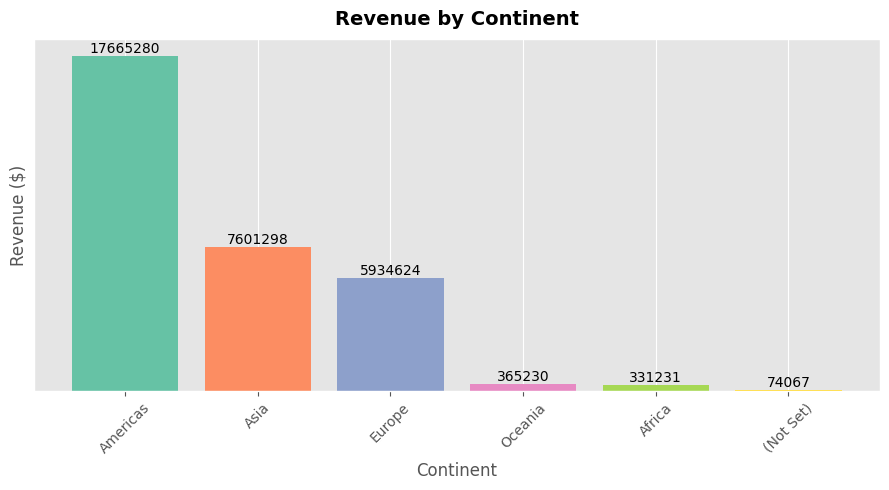

In [14]:
# Create bar plot to show top continents by revenue

plt.figure(figsize= (9, 5))
plt.style.use('ggplot')
palette_1 = sns.color_palette("Set2", n_colors= len(df_sales_by_continent))

bars = plt.bar(
    df_sales_by_continent.index,
    height= df_sales_by_continent["Revenue"],
    color= palette_1
)

plt.title("Revenue by Continent",fontsize =14, fontweight = "bold", pad =10)

plt.xlabel("Continent", fontsize= 12)
plt.ylabel("Revenue ($)", fontsize =12)

plt.yticks([])
plt.xticks(rotation =45)

for bar in bars:
  yval= bar.get_height()
  plt.text(
      bar.get_x() + bar.get_width()/2,
      yval + 7, round(yval),
      ha='center',
      va='bottom'
      )

plt.tight_layout()
plt.show()

In [15]:
# Determine top countries by revenue and order count

df_sales_by_country = calculate_summary_by_group(df_sales, "country")
print("Top-5 Countries by Revenue:\n")
df_sales_by_country.head()

Top-5 Countries by Revenue:



,Revenue,Revenue %,Order Count,Count %
country,,,,
United States,13943553.9,43.61,14673,43.75
India,2809762.0,8.79,3029,9.03
Canada,2437921.0,7.63,2560,7.63
United Kingdom,938317.9,2.93,1029,3.07
France,710692.8,2.22,678,2.02


In [16]:
# identify the highest-revenue country

the_best_country_by_revenue = df_sales_by_country.index[0]
print(f"The best country by revenue: \n{the_best_country_by_revenue}")

The best country by revenue: 
United States


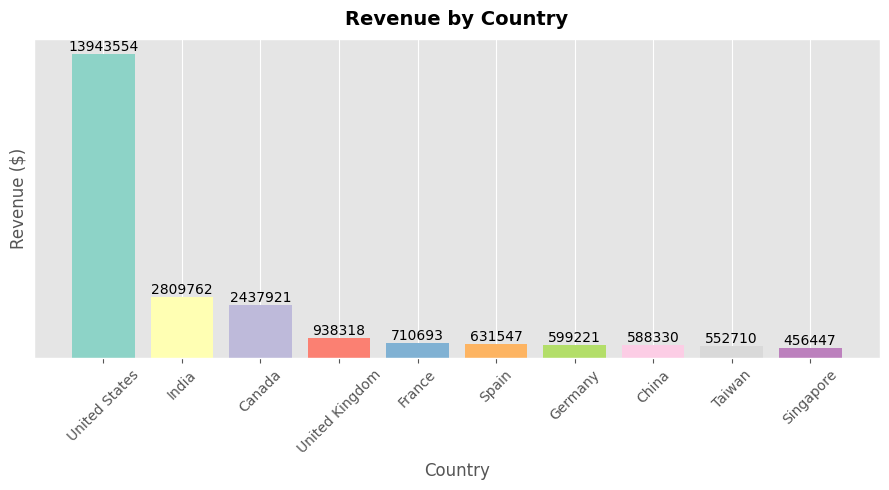

In [17]:
# Create bar plot to show top countries by revenue

top_10_countries_revenue = df_sales_by_country.head(10)

plt.figure(figsize= (9, 5))
plt.style.use('ggplot')
palette_2 = sns.color_palette("Set3", n_colors= len(df_sales_by_country))

bars = plt.bar(
    top_10_countries_revenue.index,
    height= top_10_countries_revenue["Revenue"],
    color= palette_2
    )

plt.title("Revenue by Country",fontsize =14, fontweight = "bold", pad =10)

plt.xlabel("Country", fontsize= 12)
plt.ylabel("Revenue ($)", fontsize =12)

plt.xticks(rotation =45)
plt.yticks([])

for bar in bars:
  yval= bar.get_height()
  plt.text(
      bar.get_x() + bar.get_width()/2,
      yval + 7, round(yval),
      ha='center',
      va='bottom'
      )

plt.tight_layout()
plt.show()

## 3.3. Revenue Distribution by Product Categories

In [18]:
# Determine top-10 product categories by overall revenue

df_sales_by_category = calculate_summary_by_group(df_sales, "product_category")
print('Top-10 Categories by Revenue')
df_sales_by_category.head(10)

Top-10 Categories by Revenue


,Revenue,Revenue %,Order Count,Count %
product_category,,,,
Sofas & Armchairs,8388254.5,26.24,4301,12.82
Chairs,6147748.8,19.23,5952,17.75
Beds,4919725.0,15.39,2926,8.72
Bookcases & Shelving Units,3640818.1,11.39,7630,22.75
Cabinets & Cupboards,2336499.5,7.31,2318,6.91
Outdoor Furniture,2142222.2,6.70,2229,6.65
Tables & Desks,1790307.5,5.60,2941,8.77
Chests Of Drawers & Drawer Units,906562.5,2.84,1452,4.33
Bar Furniture,735503.0,2.30,1092,3.26


In [19]:
# Determine top-10 product categories by overall revenue in the country with the best sales

df_sales_in_top_country = df_sales[df_sales['country'] == the_best_country_by_revenue]
df_sales_by_category_top_country = calculate_summary_by_group(df_sales_in_top_country, "product_category")

print(f"Top 10 product categories by revenue in the best country by sales:")
df_sales_by_category_top_country.head(10)


Top 10 product categories by revenue in the best country by sales:


,Revenue,Revenue %,Order Count,Count %
product_category,,,,
Sofas & Armchairs,3707144.5,26.59,1903,12.97
Chairs,2619773.8,18.79,2576,17.56
Beds,2213058.0,15.87,1298,8.85
Bookcases & Shelving Units,1567606.9,11.24,3374,22.99
Cabinets & Cupboards,994545.5,7.13,995,6.78
Outdoor Furniture,929245.2,6.66,984,6.71
Tables & Desks,777865.0,5.58,1248,8.51
Chests Of Drawers & Drawer Units,382388.0,2.74,616,4.20
Bar Furniture,330805.0,2.37,487,3.32


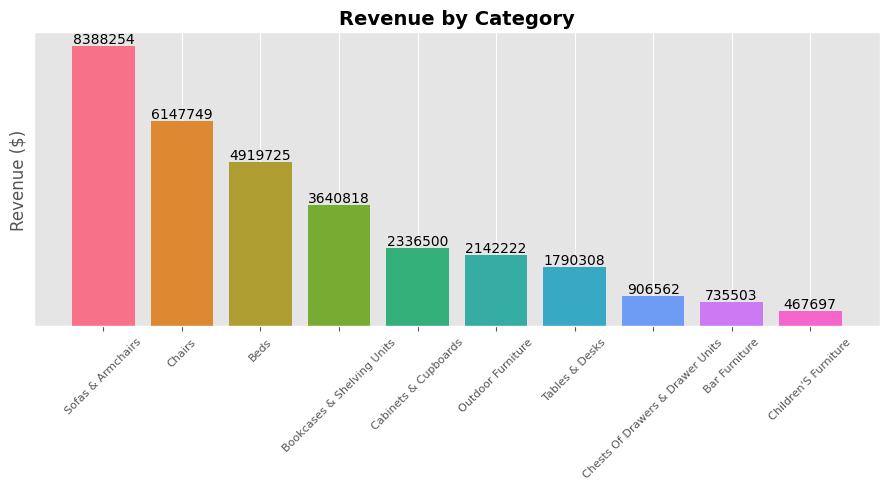

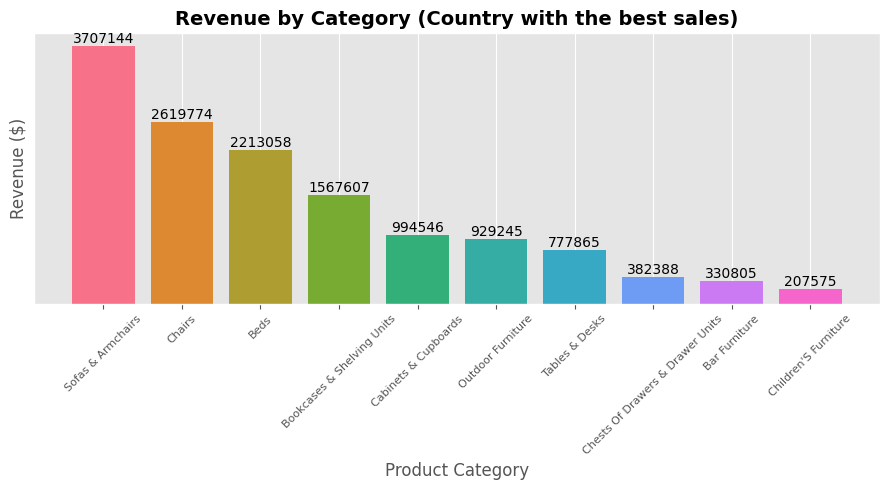

In [20]:
# Create bar plot to show top categories by revenue

top10_categories_by_revenue = df_sales_by_category.head(10)

plt.figure(figsize= (9, 5))
plt.style.use('ggplot')
palette_3 = sns.color_palette('husl', n_colors= len(top10_categories_by_revenue ))

bars = plt.bar(
    top10_categories_by_revenue.index,
    height= top10_categories_by_revenue["Revenue"],
    color= palette_3
    )

plt.title("Revenue by Category",fontsize =14, fontweight = "bold")

plt.ylabel("Revenue ($)", fontsize =12)

plt.yticks([])
plt.xticks(rotation =45, fontsize = 8)

for bar in bars:
  yval= bar.get_height()
  plt.text(
      bar.get_x() + bar.get_width()/2,
      yval + 7, round(yval),
      ha='center',
      va='bottom'
      )

plt.tight_layout()

# Create bar plot to show top categories by revenue in the coutnry with the best sales

df_sales_top_categories_in_top_country = df_sales_by_category_top_country.head(10)

plt.figure(figsize= (9, 5))

bars = plt.bar(
    df_sales_top_categories_in_top_country.index,
    height= df_sales_top_categories_in_top_country["Revenue"],
    color= palette_3
    )

plt.title("Revenue by Category (Country with the best sales)",fontsize =14, fontweight = "bold")

plt.xlabel("Product Category", fontsize= 12)
plt.ylabel("Revenue ($)", fontsize =12)

plt.yticks([])
plt.xticks(rotation =45, fontsize = 8)
for bar in bars:
  yval= bar.get_height()
  plt.text(
      bar.get_x() + bar.get_width()/2,
      yval + 7,
      round(yval),
      ha='center',
      va='bottom'
      )

plt.tight_layout()
plt.show()

## 3.4. Revenue by Device, Traffic Source, Channel, and Mobile Model

In [21]:
# Helper functions for analyzing and visualizing revenue distribution
# # Calculates total and percentage revenue distribution by a specified column

def sales_analysis (df_sales, column):
    # Group by the selected column and calculate total revenue
    df_sales_column = df_sales.groupby(column)['price'].sum().sort_values(ascending = False)
    df_sales_column = pd.DataFrame(df_sales_column)

    # Add percentage contribution to total revenue
    df_sales_column['% of revenue'] = (df_sales_column['price'] / df_sales_column['price'].sum() * 100).round(2)

    # Rename the column for clarity
    df_sales_column = df_sales_column.rename(columns={'price': 'revenue'})

    # Output the result
    print(f"Revenue Distribution by '{column}':")
    print(df_sales_column)
    print()

    return df_sales_column

# Plots a pie chart showing revenue distribution for a specific column

def plot_sales_pie(df_sales_column, column_name, top_n=5, ax = None):
    df_plot = df_sales_column.copy()

    # Identify and sum up revenue from "Other"-like labels
    other_labels = ['Other', '<Other>']
    others_from_source = df_plot[df_plot.index.isin(other_labels)]
    others_sum = others_from_source['revenue'].sum()
    df_plot = df_plot[~df_plot.index.isin(other_labels)]

    # If more than top_n entries, group the rest as "Other"
    if len(df_plot) > top_n:
        other_tail = df_plot.iloc[top_n:]
        others_sum += other_tail['revenue'].sum()
        df_plot = df_plot.iloc[:top_n]

    # Add a single 'Other' row
    if others_sum > 0:
        total_revenue = df_plot['revenue'].sum() + others_sum
        df_plot.loc['Other'] = [
            others_sum,
            round(others_sum / total_revenue * 100, 2)
        ]

    # Plot the pie chart
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.5, 3.5))

    ax.pie(
        df_plot['revenue'],
        labels=df_plot.index,
        autopct='%1.1f%%',
        colors= palette_1,
        startangle=90,
        counterclock=False,
        textprops={'fontsize': 8}
    )

    ax.set_title(f"Revenue Distribution by {column_name.title()}", fontsize = 12)
    ax.axis('equal')

In [22]:
# Determine revenue distribution by different columns

df_devices = sales_analysis(df_sales, 'device')
df_mobile_model_name = sales_analysis(df_sales, 'mobile_model_name')
df_traffic = sales_analysis(df_sales, 'traffic_source')
df_channel = sales_analysis(df_sales, 'channel')


Revenue Distribution by 'device':
            revenue  % of revenue
device                           
Desktop  18864039.0         59.00
Mobile   12384225.8         38.73
Tablet     723466.3          2.26

Revenue Distribution by 'mobile_model_name':
                     revenue  % of revenue
mobile_model_name                         
Chrome             8899523.9         27.84
<Other>            6535330.8         20.44
Safari             6491062.1         20.30
Iphone             6420776.3         20.08
Chromebook         1830458.7          5.73
Edge                697222.3          2.18
Ipad                448854.2          1.40
Firefox             421066.9          1.32
Pixel 4 Xl          118287.7          0.37
Pixel 3             109148.2          0.34

Revenue Distribution by 'traffic_source':
                   revenue  % of revenue
traffic_source                          
(Organic)       10935239.9         34.20
(Direct)         7494923.4         23.44
<Other>          5897375.6 

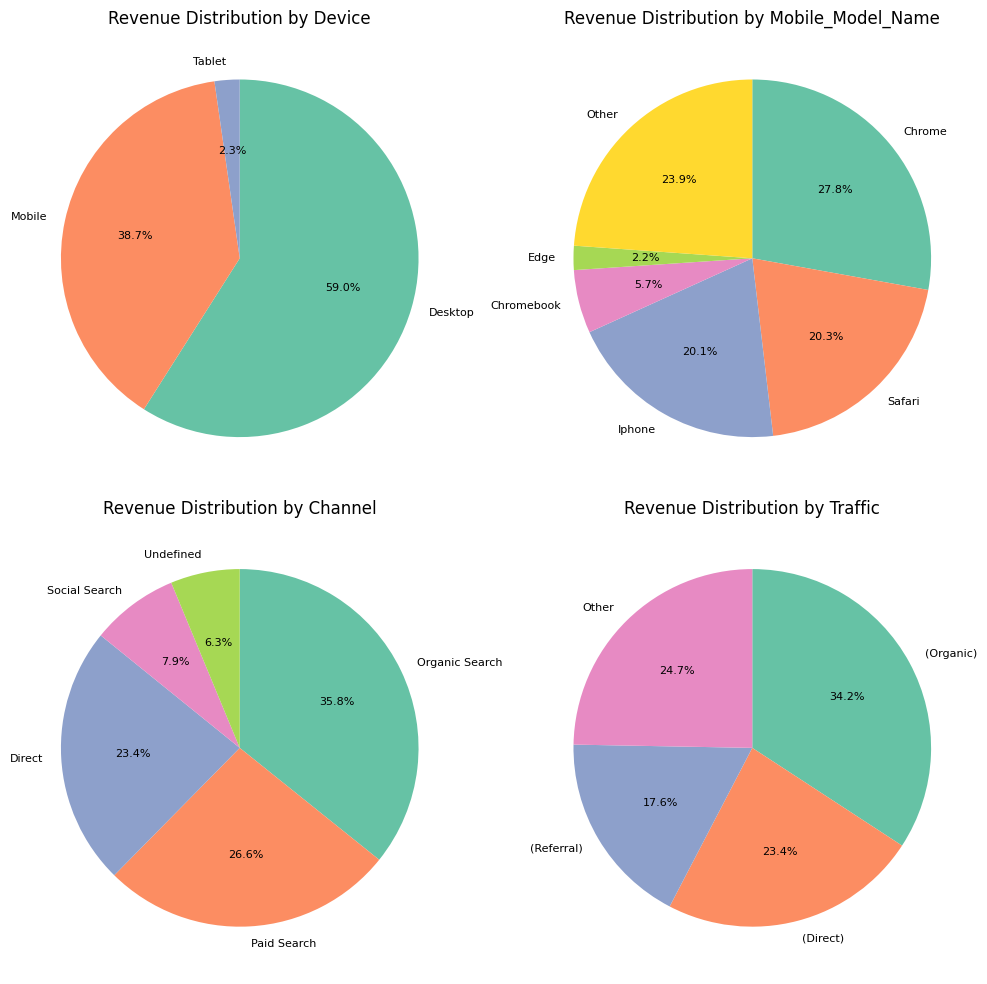

In [23]:
# pie chart visualisation for different columns

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plot_sales_pie(df_devices, 'device', ax=axs[0, 0])
plot_sales_pie(df_mobile_model_name, 'mobile_model_name', ax=axs[0, 1])
plot_sales_pie(df_channel, 'channel', top_n=10, ax=axs[1, 0])
plot_sales_pie(df_traffic, 'traffic', top_n=3, ax=axs[1, 1])

plt.tight_layout()
plt.show()

## 3.5. User Engagement and Subscription Behavior

In [24]:
df_account = df_cleaned[df_cleaned["account_id"].notna()].copy()
df_account.info()
df_account.head()

<class 'pandas.core.frame.DataFrame'>
Index: 27945 entries, 16 to 349523
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_date         2781 non-null   datetime64[ns]
 1   ga_session_id      27945 non-null  Int64         
 2   continent          27945 non-null  object        
 3   country            27945 non-null  object        
 4   device             27945 non-null  object        
 5   browser            27945 non-null  object        
 6   mobile_model_name  27945 non-null  object        
 7   operating_system   27945 non-null  object        
 8   browser_language   27945 non-null  object        
 9   traffic_source     27945 non-null  object        
 10  channel            27945 non-null  object        
 11  account_id         27945 non-null  Int64         
 12  is_verified        27945 non-null  Int64         
 13  is_unsubscribed    27945 non-null  Int64         
 14  product_c

,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,browser_language,traffic_source,channel,account_id,is_verified,is_unsubscribed,product_category,product_name,price,short_description,session_date
16,NaT,431917304,(Not Set),(Not Set),Desktop,Chrome,Safari,Web,En-Us,(Referral),Paid Search,671686,1,0,None,None,NaN,None,2020-11-15
21,NaT,3398633441,(Not Set),(Not Set),Desktop,Chrome,Chrome,Web,En,<Other>,Paid Search,645196,1,0,None,None,NaN,None,2020-12-10
26,NaT,6220644531,(Not Set),(Not Set),Mobile,Android Webview,<Other>,Web,En-Us,<Other>,Paid Search,650928,1,1,None,None,NaN,None,2021-01-25
58,NaT,3055336399,(Not Set),(Not Set),Desktop,Chrome,Safari,Web,Unknown,(Direct),Direct,651913,0,0,None,None,NaN,None,2020-11-12
63,NaT,5588529262,(Not Set),(Not Set),Desktop,Chrome,Chrome,Web,En-Gb,<Other>,Paid Search,664804,1,0,None,None,NaN,None,2021-01-07


In [25]:
# Determine key account metrics

total_account_count = len(df_account['account_id'].unique())
print(f"Total number of accounts: {total_account_count}")

count_is_verified = (df_account['is_verified'] == 1).sum()
print(f"\nNumber of verified accounts:{count_is_verified}")
print(f"Percentage of verified accounts to total accounts: {round(count_is_verified / total_account_count *100, 2)} %")

count_is_unsubscribed = (df_account['is_unsubscribed'] == 1).sum()
print(f"\nNumber of unsubscribed accounts:{count_is_unsubscribed}")
print(f"Percentage of unsubscribed accounts to total accounts: {round(count_is_unsubscribed / total_account_count *100, 2)} %")


Total number of accounts: 27945

Number of verified accounts:20036
Percentage of verified accounts to total accounts: 71.7 %

Number of unsubscribed accounts:4735
Percentage of unsubscribed accounts to total accounts: 16.94 %


In [26]:
for column in columns_to_normalize:
  df_account[column] = df_account[column].str.title()

df_account_sales = df_account[df_account['order_date'].notna()].copy()
df_account_sales.info()
df_account_sales.head()


<class 'pandas.core.frame.DataFrame'>
Index: 2781 entries, 137 to 349470
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_date         2781 non-null   datetime64[ns]
 1   ga_session_id      2781 non-null   Int64         
 2   continent          2781 non-null   object        
 3   country            2781 non-null   object        
 4   device             2781 non-null   object        
 5   browser            2781 non-null   object        
 6   mobile_model_name  2781 non-null   object        
 7   operating_system   2781 non-null   object        
 8   browser_language   2781 non-null   object        
 9   traffic_source     2781 non-null   object        
 10  channel            2781 non-null   object        
 11  account_id         2781 non-null   Int64         
 12  is_verified        2781 non-null   Int64         
 13  is_unsubscribed    2781 non-null   Int64         
 14  product_c

,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,browser_language,traffic_source,channel,account_id,is_verified,is_unsubscribed,product_category,product_name,price,short_description,session_date
137,2020-12-14,3092996681,(Not Set),(Not Set),Desktop,Chrome,Safari,Web,Unknown,(Direct),Direct,677526,1,0,Chairs,MELLTORP / TEODORES,289.0,"Table and 2 chairs, 75x75 cm",2020-12-14
585,2020-11-18,7319736614,Asia,India,Desktop,Chrome,Chrome,Web,Unknown,(Direct),Direct,668188,0,0,Bookcases & Shelving Units,JONAXEL,990.0,"Frame/mesh baskets/shelving units, 148x51x173 cm",2020-11-18
591,2021-01-25,5185043541,Asia,Singapore,Desktop,Chrome,Chrome,Web,En-Us,(Direct),Direct,677836,0,0,Chairs,BÖRJE,175.0,Chair,2021-01-25
856,2020-12-17,2323592862,Asia,Japan,Desktop,Chrome,Safari,Web,En-Us,(Direct),Direct,680278,1,0,Bookcases & Shelving Units,KOLBJÖRN,695.0,"Cabinet in/outdoor, 90x161 cm",2020-12-17
863,2020-12-15,6598739264,Asia,India,Desktop,Chrome,Safari,Web,En-Us,(Direct),Direct,659532,1,0,Tables & Desks,LINNMON / ADILS,175.0,"Table, 120x60 cm",2020-12-15


In [27]:
account_sales_total = df_account_sales['price'].sum()
print(f"Total revenue by customer with account : {account_sales_total}\n")

# sales analysis for customer with verified account

account_revenue_is_verified = df_account_sales[df_account_sales["is_verified"] == 1]['price'].sum()
account_revenue_is_verified_avg = df_account_sales[df_account_sales["is_verified"] == 1]['price'].mean()
account_orders_is_verified = df_account_sales[df_account_sales["is_verified"] == 1]['price'].count()
print(f"Revenue by customer with verified account: {account_revenue_is_verified:.2f}")
print(f"Average revenue by customer with verified account: {account_revenue_is_verified_avg:.2f}")
print(f"Count of orders by customer with verified account: {account_orders_is_verified}\n")

# sales analysis for customer with unsubscribed account

account_revenue_is_unsubscribed = df_account_sales[df_account_sales['is_unsubscribed'] == 1]["price"].sum()
account_revenue_is_unsubscribed_avg = df_account_sales[df_account_sales['is_unsubscribed'] == 1]["price"].mean()
account_orders_is_unsubscribed = df_account_sales[df_account_sales["is_unsubscribed"] == 1]['price'].count()
print(f"Revenue by customer with unsubscribed account: {account_revenue_is_unsubscribed}")
print(f"Average revenue by customer with unsubscribed account: {account_revenue_is_unsubscribed_avg:.2f}")
print(f"Count of orders by customer with unsubscribed account: {account_orders_is_unsubscribed}\n")

Total revenue by customer with account : 2582518.5

Revenue by customer with verified account: 1866017.40
Average revenue by customer with verified account: 938.17
Count of orders by customer with verified account: 1989

Revenue by customer with unsubscribed account: 431721.6
Average revenue by customer with unsubscribed account: 965.82
Count of orders by customer with unsubscribed account: 447



In [28]:
verified = df_account_sales[df_account_sales["is_verified"] == 1]
unsubscribed = df_account_sales[df_account_sales["is_unsubscribed"] == 1]
verified_by_date_revenue = verified.groupby('order_date')["price"].sum().reset_index()
unsubscribed_by_date_revenue = unsubscribed.groupby('order_date')['price'].sum().reset_index()
verified_by_date_revenue.rename(columns={"price": "verified_revenue"}, inplace=True)
unsubscribed_by_date_revenue.rename(columns={"price": "unsubscribed_revenue"}, inplace=True)

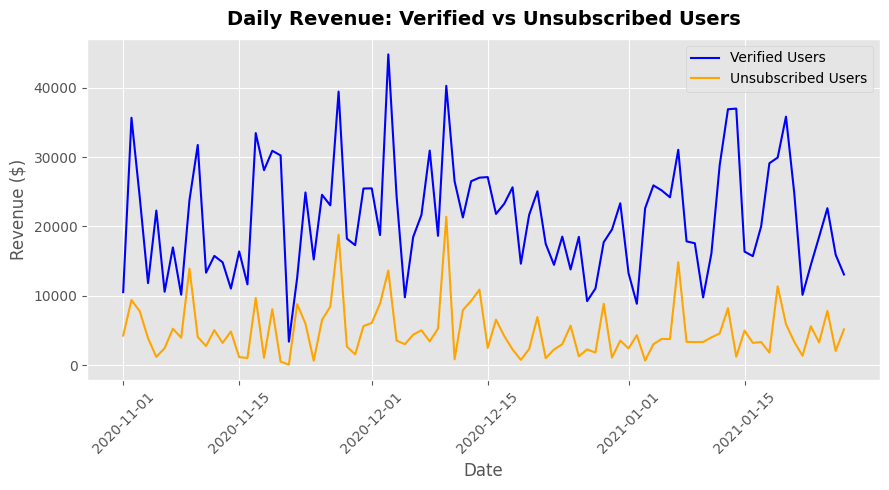

In [29]:
# Create a line plot to show difference in revenue between verified and unsubscribed users

combined_users = pd.merge(
    verified_by_date_revenue,
    unsubscribed_by_date_revenue,
    on="order_date",
    how="inner"
)

plt.figure(figsize=(9, 5))

plt.plot(
    combined_users["order_date"],
    combined_users["verified_revenue"],
    label="Verified Users",
    color="blue"
    )

plt.plot(
    combined_users["order_date"],
    combined_users["unsubscribed_revenue"],
    label="Unsubscribed Users",
    color="orange"
    )

plt.title("Daily Revenue: Verified vs Unsubscribed Users", fontsize=14, fontweight="bold", pad= 10)

plt.xlabel("Date")
plt.ylabel("Revenue ($)")

plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
# top 10 countries with the highest number of vaccounts

df_account_number = df_account.groupby('country').size().sort_values(ascending = False).head(10)
print("Top 10 countries by account number")
print(df_account_number)
print()

# top 10 countries with the highest number of verified accounts

print("Top 10 countries by verified account number")
df_account_verified = df_account[df_account['is_verified'] == 1].groupby('country').size().sort_values(ascending = False).head(10)
print(df_account_verified)

Top 10 countries by account number
country
United States     12384
India              2687
Canada             2067
United Kingdom      859
France              553
Spain               536
Taiwan              500
China               490
Germany             490
Italy               386
dtype: int64

Top 10 countries by verified account number
country
United States     8889
India             1927
Canada            1486
United Kingdom     601
France             388
Spain              380
Taiwan             348
Germany            345
China              344
Italy              285
dtype: int64


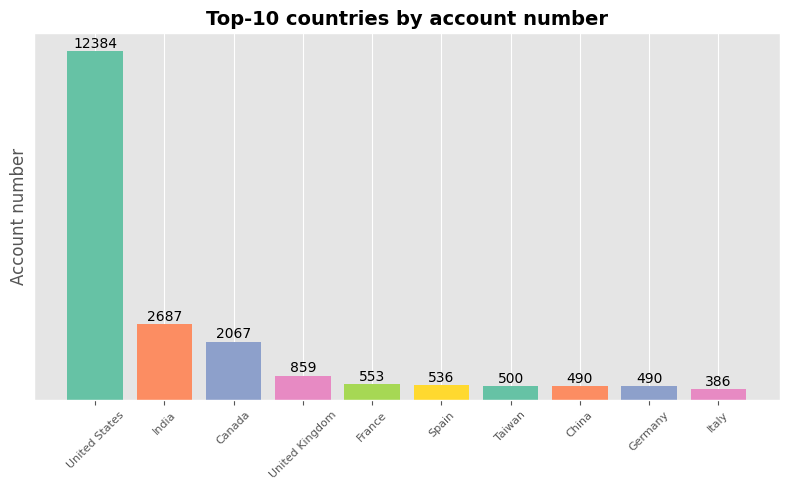

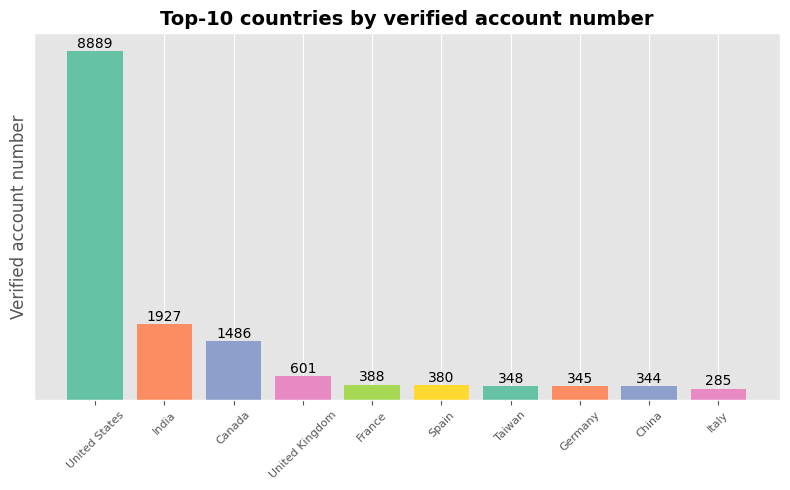

In [31]:
# Visualisation Top-10 countries by account count, Top-10 countries by verified account count

plt.figure(figsize = (8,5))

bars = plt.bar(
    x=df_account_number.index,
    height= df_account_number.values,
    color = palette_1)

plt.title("Top-10 countries by account number", fontsize =14, fontweight = "bold")

plt.ylabel("Account number", fontsize =12)

plt.yticks([])
plt.xticks(rotation =45, fontsize = 8)

for bar in bars:
  yval= bar.get_height()
  plt.text(
      bar.get_x() + bar.get_width()/2,
      yval + 7, round(yval),
      ha='center',
      va='bottom'
      )

plt.tight_layout()

plt.figure(figsize = (8,5))

bars = plt.bar(
    x=df_account_verified.index,
    height= df_account_verified.values,
    color = palette_1
    )

plt.title("Top-10 countries by verified account number", fontsize =14, fontweight = "bold")

plt.ylabel("Verified account number", fontsize =12)

plt.yticks([])
plt.xticks(rotation =45, fontsize = 8)

for bar in bars:
  yval= bar.get_height()
  plt.text(
      bar.get_x() + bar.get_width()/2,
      yval + 7, round(yval),
      ha='center',
      va='bottom'
      )

plt.tight_layout()
plt.show()



## 3.6 Summary: Key Sales and User Metrics Analysis

This section provides a high-level overview of sales performance and user behavior based on the available dataset.

#### **Sales Metrics**

- **Total revenue**: `$31,971,731.10`  
- **Total number of orders**: `33,538`  
- **Average revenue per order**: `$953.30`  

**Top-performing countries by revenue**:
- United States – `$13.94M`

- India – `$2.81M`

- Canada – `$2.44M`

**Top 3 product categories by revenue**:
- **Sofas & Armchairs** – `$8.39M`
- **Chairs** – `$6.15M`
- **Beds** – `$4.92M`

These categories also led in the U.S. market, with **Sofas & Armchairs** generating over `$3.7M`.

#### **Revenue Distribution Insights**

- **Desktop** devices contributed the highest share of revenue: **59.0%**
- Most used mobile browser by revenue: **Chrome (27.8%)**
- Key acquisition sources:
  - **Organic Search** – 35.8%
  - **Organic Traffic** – 34.2%

#### **User Metrics**

- **Verified customers**:
  - Total revenue: `$1,866,017.40`
  - Average revenue per customer: `$938.17`
  - Total orders: `1,989`

- **Unsubscribed customers**:
  - Total revenue: `$431,721.60`
  - Average revenue per customer: `$965.82`
  - Total orders: `447`

- **Top countries by total account number**:
  - United States – `12,384`
  - India – `2,687`
  - Canada – `2,067`

- **Top countries by verified account number**:
  - United States – `8,889`
  - India – `1,927`
  - Canada – `1,486`

- **Daily Revenue: Verified vs Unsubscribed Users**  
  A line chart comparison shows **identical behavior patterns over time** between verified and unsubscribed users, indicating similar engagement cycles regardless of account status.



# **4. SALES DYNAMICS ANALYSIS**

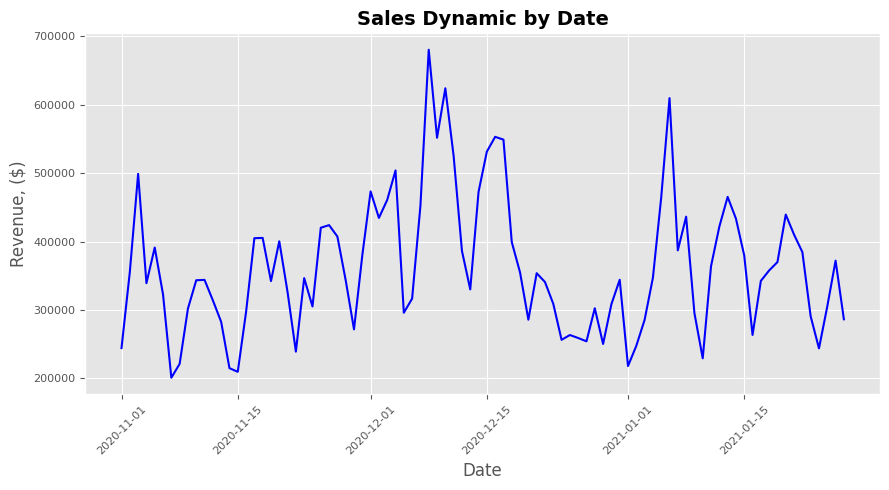

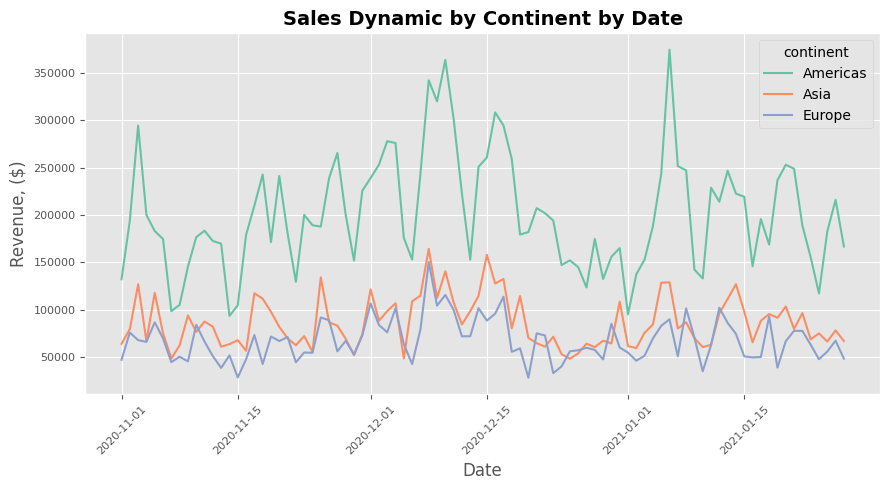

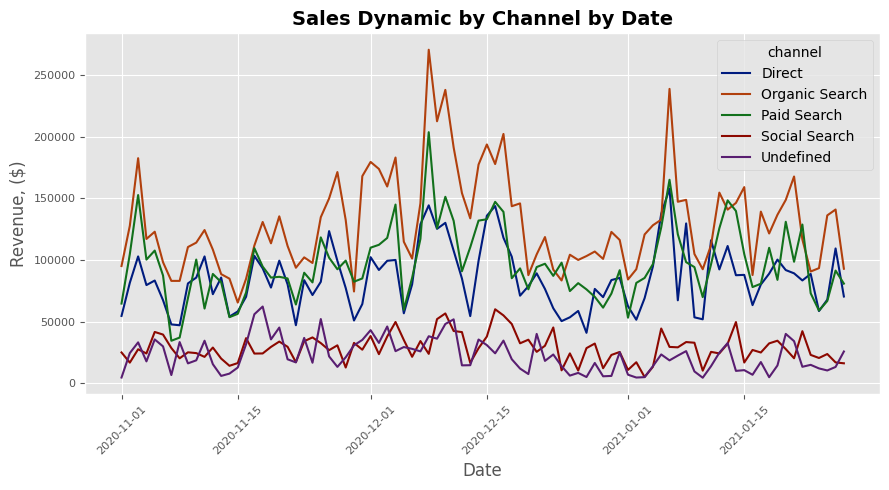

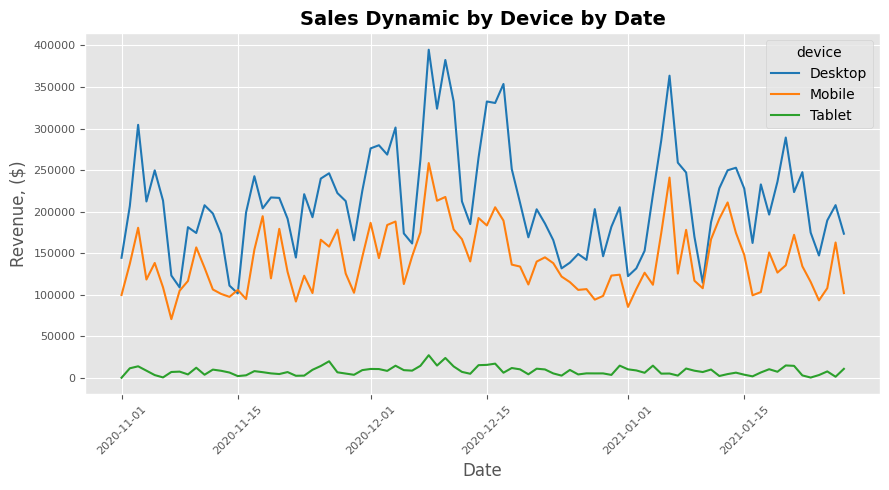

In [32]:
# Plotting overall sales dynamics over time
plt.figure(figsize= (9, 5))

df_sales_by_date = df_sales.groupby("order_date")["price"].sum()

sns.lineplot(
    x=df_sales_by_date.index,
    y=df_sales_by_date.values,
    color = 'blue'
    )

plt.title("Sales Dynamic by Date", fontsize= 14, fontweight = "bold")

plt.xlabel("Date")
plt.ylabel("Revenue, ($)")

plt.xticks(rotation =45, fontsize= 8)
plt.yticks(fontsize = 8)

plt.tight_layout()
plt.show()

# Plotting sales dynamics by continent (top-3) over time

plt.figure(figsize= (9, 5))

df_sales_by_date_continent = df_sales.groupby(["order_date", "continent"])["price"].sum().reset_index()
top_3_continent_by_revenue_names = df_sales_by_continent.head(3).index.tolist()
df_sales_by_date_continent_top = df_sales_by_date_continent[df_sales_by_date_continent['continent'].isin(top_3_continent_by_revenue_names)]

sns.lineplot(
    df_sales_by_date_continent_top,
    x= "order_date", y= "price",
    hue = "continent",
    palette = "Set2"
    )

plt.title("Sales Dynamic by Continent by Date", fontsize= 14, fontweight = "bold")

plt.xlabel("Date")
plt.ylabel("Revenue, ($)")

plt.xticks(rotation =45, fontsize= 8)
plt.yticks(fontsize = 8)

plt.tight_layout()
plt.show()

# Plotting sales dynamics  by channel over time

plt.figure(figsize= (9, 5))

df_sales_by_date_channel = df_sales.groupby(["order_date", "channel"])["price"].sum().reset_index()

sns.lineplot(df_sales_by_date_channel, x= "order_date", y= "price", hue = "channel", palette = "dark")
plt.title(
    "Sales Dynamic by Channel by Date",
    fontsize= 14,
    fontweight = "bold"
    )

plt.xlabel("Date")
plt.ylabel("Revenue, ($)")

plt.xticks(rotation =45, fontsize= 8)
plt.yticks(fontsize = 8)

plt.tight_layout()
plt.show()

# Plotting sales dynamics  by device over time

plt.figure(figsize= (9, 5))

df_sales_by_date_device = df_sales.groupby(["order_date", "device"])["price"].sum().reset_index()

sns.lineplot(
    df_sales_by_date_device,
    x= "order_date", y= "price",
    hue = "device",
    palette = "tab10"
    )

plt.title("Sales Dynamic by Device by Date", fontsize= 14, fontweight = "bold")

plt.xlabel("Date")
plt.ylabel("Revenue, ($)")

plt.xticks(rotation =45, fontsize= 8)
plt.yticks(fontsize = 8)

plt.tight_layout()
plt.show()

The analysis of sales dynamics through visualization showed that the overall trend in the distribution of sales across continents, devices, and sales channels remained consistent throughout the entire period. Total sales, as well as sales by segment, peaked in early November, mid-December (before Christmas), and early January.

# **5. PIVOT TABLES AND AGGREGATED METRICS**

In [33]:
# Create a pivot table to analyze the number of unique sessions (ga_session_id)
# by marketing channel and device type

pivot_session = pd.pivot_table(
    df_cleaned,
    index='channel',
    columns='device',
    values='ga_session_id',
    aggfunc=pd.Series.nunique
)

pivot_session.head()

device,Desktop,Mobile,Tablet
channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638
Undefined,12527,8486,470


In [34]:
# Create a pivot table to analyze the number of unique sessions with order (ga_session_id)
# by marketing channel and device type

pivot_session_sales = pd.pivot_table(
    df_sales,
    index='channel',
    columns='device',
    values='ga_session_id',
    aggfunc=pd.Series.nunique
)
pivot_session_sales.head(10)

device,Desktop,Mobile,Tablet
channel,,,
Direct,4655,2985,160
Organic Search,7011,4655,255
Paid Search,5261,3574,207
Social Search,1594,1065,57
Undefined,1181,834,44


In [35]:
# Filter the sales data to include only the top 10 countries by total revenue.

top_10_countries_revenue_1 = top_10_countries_revenue.index.to_list()
df_top_10_countries = df_sales[df_sales["country"].isin(top_10_countries_revenue_1)]

# Сreate a pivot table that shows the total revenue (price) per product category for each country

pivot_categories_countries_top = pd.pivot_table(
    df_top_10_countries,
    index= "country",
    columns = 'product_category',
    values = 'price',
    aggfunc= "sum"
    )

pivot_with_total = pivot_categories_countries_top.copy()
pivot_with_total["total"] = pivot_with_total.sum(axis=1)
pivot_country_sorted = pivot_with_total.sort_values(by="total", ascending=False)
pivot_country_sorted

product_category,Bar Furniture,Beds,Bookcases & Shelving Units,Cabinets & Cupboards,Café Furniture,Chairs,Chests Of Drawers & Drawer Units,Children'S Furniture,Nursery Furniture,Outdoor Furniture,Room Dividers,"Sideboards, Buffets & Console Tables",Sofas & Armchairs,Tables & Desks,total
country,,,,,,,,,,,,,,,
United States,330805.0,2213058.0,1567606.9,994545.5,59000.0,2619773.8,382388.0,207575.0,65998.0,929245.2,30439.0,58110.0,3707144.5,777865.0,13943553.9
India,57657.0,358319.5,364507.4,191888.0,13738.0,544309.2,73111.0,39177.0,11516.0,162289.4,8072.0,10590.0,788430.0,186157.5,2809762.0
Canada,51724.0,354772.0,278981.9,181802.0,13368.0,417740.8,71952.0,30264.0,11090.0,185322.8,10168.0,5630.0,692427.5,132678.0,2437921.0
United Kingdom,22103.0,133816.0,113987.6,71684.5,4554.0,188519.4,36784.0,13348.0,2775.0,57002.4,5458.0,4100.0,234812.0,49374.0,938317.9
France,11199.0,116414.0,73830.0,59101.5,2299.0,134029.4,21544.5,14258.0,4968.0,40486.4,2034.0,495.0,187735.0,42299.0,710692.8
Spain,15626.0,86336.0,54386.9,44471.0,3951.0,122558.2,24248.5,9520.0,1458.0,35642.6,695.0,6620.0,180660.5,45373.0,631546.7
Germany,7939.0,81280.0,61254.2,38481.0,2811.0,123979.0,18822.0,7431.0,1955.0,68522.2,5111.0,2350.0,147632.5,31653.5,599221.4
China,9143.0,107051.0,67909.1,42745.0,2214.0,130800.0,19827.0,9805.0,2210.0,31876.0,2734.0,740.0,144430.0,16845.5,588329.6
Taiwan,16052.0,109631.0,62947.4,41081.0,3631.0,121097.0,16258.0,10422.0,1169.0,17831.4,2397.0,NaN,126981.0,23212.5,552710.3


In [36]:
# Сreate a pivot table that shows the total revenue (price) per product category for each continent


pivot_categories_continent = pd.pivot_table(
    df_sales,
    index= "continent",
    columns = 'product_category',
    values = 'price',
    aggfunc= "sum"
    )

pivot_categories_continent

product_category,Bar Furniture,Beds,Bookcases & Shelving Units,Cabinets & Cupboards,Café Furniture,Chairs,Chests Of Drawers & Drawer Units,Children'S Furniture,Nursery Furniture,Outdoor Furniture,Room Dividers,"Sideboards, Buffets & Console Tables",Sofas & Armchairs,Tables & Desks
continent,,,,,,,,,,,,,,
(Not Set),NaN,9565.0,2597.0,5127.0,450.0,17131.0,2010.0,118.0,200.0,3131.4,2397.0,NaN,23345.0,7996.0
Africa,10724.0,57567.5,32996.7,21106.0,940.0,44877.0,10941.0,3962.0,1995.0,16343.8,NaN,NaN,108120.0,21658.0
Americas,406198.0,2773094.0,1968919.3,1275562.5,77318.0,3309203.0,484290.0,253435.0,80983.0,1213115.2,44571.0,73155.0,4737307.0,968129.0
Asia,176684.0,1077325.5,945368.9,545369.5,29458.0,1524600.8,210383.5,112389.0,30551.0,488607.6,22231.0,24115.0,1950022.0,464192.5
Europe,131110.0,925047.5,650889.5,468652.5,28812.0,1178581.0,186793.0,93479.0,26168.0,399553.2,19899.0,27370.0,1491224.5,307045.0
Oceania,10787.0,77125.5,40046.7,20682.0,1190.0,73356.0,12145.0,4314.0,1710.0,21471.0,1190.0,1690.0,78236.0,21287.0


Pivot tables were used to explore session behavior and revenue distribution:

Sessions & Orders:
Unique sessions and sessions with orders were analyzed by marketing channel and device type. Organic Search showed high engagement, while Desktop users generated the most purchases.

Revenue by Product:
Total revenue by product category was compared across countries and continents. Sofas & Armchairs and Chairs led in most top-performing regions, especially in North America and the United States.

These insights highlight how user behavior and product performance vary across traffic sources, devices, and geography.

# **6. STATISTICAL ANALYSIS OF RELATIONSHIP**

## **6.1. Correlation Between Sessions and Revenue**

In [37]:
# Count the number of sessions per day

sessions_per_day = df_cleaned.groupby("session_date").size().reset_index(name="session_count")

# Calculate total revenue per day (only for days with at least one purchase)

revenue_per_day = df_sales[df_sales["order_date"].notna()].groupby("order_date")["price"].sum().reset_index()
revenue_per_day.rename(columns={"order_date": "session_date", "price": "revenue"}, inplace=True)

# Merge session counts with daily revenue to ensure all session days are included, even if revenue is zero

df_merged_session = pd.merge(sessions_per_day, revenue_per_day, on = "session_date", how = 'left')

# Remove rows with missing values to ensure clean data for applying correlation analysis

df_merged_session_clean = df_merged_session.dropna()
df_merged_session_clean.head()


,session_date,session_count,revenue
0,2020-11-01,2576,244292.5
1,2020-11-02,3599,355506.8
2,2020-11-03,5173,498979.6
3,2020-11-04,4184,339187.1
4,2020-11-05,3743,391276.6


In [38]:
# Since we will be provide analysis multiple times,
# it is reasonable to define a function to test the normality of data
# distributions in selected columns using the Shapiro-Wilk test.

def shapiro_test (df, columns):
    for column in columns:
      stat, p = shapiro(df[column])
      print(f"Distribution in {column} - normality p-value: {p:.4f}")
      if p <= 0.05:
        print(f"The distribution in {column} is not normal.\n")
      else:
        print(f"The distribution in {column} appears to be normal.\n")

In [39]:
# Test normality of 'session_count' and 'revenue' columns using Shapiro-Wilk test

columns_session = ["session_count", "revenue"]
shapiro_test(df_merged_session_clean, columns_session)

Distribution in session_count - normality p-value: 0.0395
The distribution in session_count is not normal.

Distribution in revenue - normality p-value: 0.0048
The distribution in revenue is not normal.



Conclusion:

Both 'session_count' and 'revenue' failed the Shapiro-Wilk normality test, with p-values of 0.0395 and 0.0048, respectively — both below the 0.05 significance threshold.
This indicates that the variables are not normally distributed. Therefore, we apply Spearman's rank correlation to assess the relationship between them.

In [40]:
# Calculate Spearman's rank correlation between 'session_count' and 'revenue'

r, p = spearmanr(df_merged_session_clean["session_count"], df_merged_session_clean["revenue"])
print(f"Correlation: r={r:.2f}, p-value={p:.4f}")


Correlation: r=0.90, p-value=0.0000


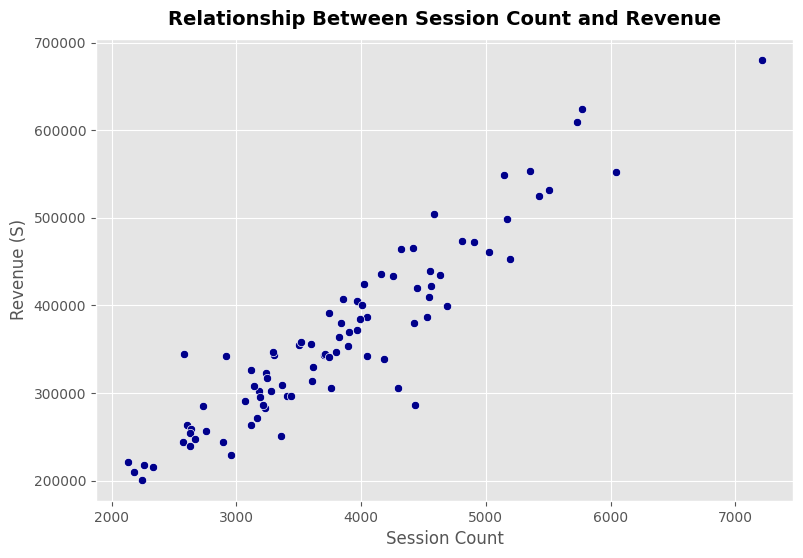

In [41]:
# Create a scatter plot to visualize the relationship between session count and revenue

plt.figure(figsize= [9,6])

sns.scatterplot(
    x="session_count",
    y="revenue",
    data=df_merged_session_clean,
    color = "darkblue"
    )

plt.title("Relationship Between Session Count and Revenue", fontsize= 14, fontweight = "bold", pad = 10)

plt.xlabel("Session Count")
plt.ylabel("Revenue (S)")

plt.show()

The Spearman correlation coefficient r = 0.90 indicates a very strong positive monotonic relationship between session_count and revenue.
The p-value is effectively 0 (less than 0.0001), which means this correlation is highly statistically significant — we reject the null hypothesis of no association.

## **6.2. Correlation Between Continents (Top-3)**

In [42]:
# Create a pivot table to show the revenue dynamics over time for the top 3 continents

pivot_top_3_continent_by_date = pd.pivot_table(
    df_sales_by_date_continent_top,
    index = "order_date",
    columns = "continent",
    values= "price",
    aggfunc= "sum"
    ).dropna()

pivot_top_3_continent_by_date.head()

continent,Americas,Asia,Europe
order_date,,,
2020-11-01,132002.5,63823.0,46908.0
2020-11-02,193861.0,79370.0,75710.8
2020-11-03,294529.8,126737.8,67692.0
2020-11-04,200009.5,66602.0,65915.0
2020-11-05,182988.2,117608.4,86540.0


In [43]:
# Test normality of top-3 continent columns using Shapiro-Wilk test

columns_continent = ["Americas", "Asia", "Europe"]
shapiro_test(pivot_top_3_continent_by_date, columns_continent)

Distribution in Americas - normality p-value: 0.0425
The distribution in Americas is not normal.

Distribution in Asia - normality p-value: 0.0004
The distribution in Asia is not normal.

Distribution in Europe - normality p-value: 0.0073
The distribution in Europe is not normal.



All three variables — "Americas",  "Asia", and "Europe" — failed the Shapiro-Wilk normality test, with p-values of 0.0425, 0.0004, and 0.0073 respectively, all below the 0.05 threshold.
This indicates that the distributions are not normal. Therefore, Spearman's rank correlation is the appropriate method to assess the relationships between them.

In [44]:
# Creating a Spearman correlation matrix

matrix_corr_continent = pivot_top_3_continent_by_date.corr(method= "spearman").round(2)
matrix_corr_continent

continent,Americas,Asia,Europe
continent,,,
Americas,1.00,0.67,0.63
Asia,0.67,1.00,0.61
Europe,0.63,0.61,1.00


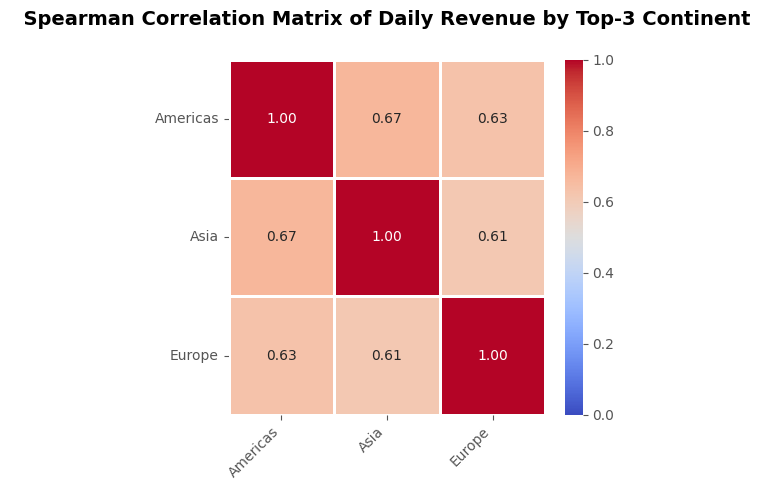

In [45]:
# Visualization of the Correlation Matrix (Heatmap)

plt.figure(figsize= (5, 5))
sns.heatmap(
    matrix_corr_continent,
    annot = True,
    cmap = "coolwarm",
    fmt = ".2f",
    linewidths= 0.75,
    vmin = 0,
    vmax= 1
)

plt.title("  Spearman Correlation Matrix of Daily Revenue by Top-3 Continent  ", fontsize=14, fontweight='bold', pad= 25)

plt.xlabel("")
plt.ylabel("")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [46]:
# Calculate Spearman correlation and p-value for each  pair to assess statistical significance.

continents = pivot_top_3_continent_by_date.columns

for i in range(len(continents)):
    for j in range(i + 1, len(continents)):
        continent1 = continents[i]
        continent2 = continents[j]
        rho, p_value = spearmanr(pivot_top_3_continent_by_date[continent1], pivot_top_3_continent_by_date[continent2])
        print(f"  {continent1} vs {continent2}: rho={rho:.2f}, p-value={p_value:.7f} {'(Statistically significant)' if p_value < 0.05 else '(Not statistically significant)'}")


  Americas vs Asia: rho=0.67, p-value=0.0000000 (Statistically significant)
  Americas vs Europe: rho=0.63, p-value=0.0000000 (Statistically significant)
  Asia vs Europe: rho=0.61, p-value=0.0000000 (Statistically significant)


Conclusion:

The Spearman correlation analysis shows statistically significant strong positive correlations in daily revenue across all three continents.

These results suggest similar revenue trends across regions, possibly due to synchronized market behavior or global campaigns.

## 6.3. Correlation Between Traffic Channels

In [47]:
# Create a pivot table to show a revenue by channel by date

pivot_table_channel = pd.pivot_table(
    df_sales,
    index = "order_date",
    columns = "channel",
    values= "price",
    aggfunc= "sum"
).dropna()

pivot_table_channel

channel,Direct,Organic Search,Paid Search,Social Search,Undefined
order_date,,,,,
2020-11-01,54669.5,95112.0,64688.0,25078.0,4745.0
2020-11-02,81561.5,127746.5,104780.8,16843.0,24575.0
2020-11-03,102909.5,182521.9,152641.3,27652.5,33254.4
2020-11-04,79683.6,117067.1,100332.0,24257.4,17847.0
2020-11-05,83367.6,122938.4,107648.0,41693.2,35629.4
...,...,...,...,...,...
2021-01-23,88714.4,90686.0,73075.1,23095.0,15035.0
2021-01-24,58644.2,93413.6,59018.0,20596.1,12146.5
2021-01-25,67844.0,136178.6,66775.7,23809.0,10482.0


In [48]:
# Test normality of channel using Shapiro-Wilk test

columns_channel = ["Direct", "Organic Search", "Paid Search", "Social Search"]
shapiro_test(pivot_table_channel, columns_channel)

Distribution in Direct - normality p-value: 0.0125
The distribution in Direct is not normal.

Distribution in Organic Search - normality p-value: 0.0001
The distribution in Organic Search is not normal.

Distribution in Paid Search - normality p-value: 0.0174
The distribution in Paid Search is not normal.

Distribution in Social Search - normality p-value: 0.1131
The distribution in Social Search appears to be normal.



Three variables — "Direct", "Organic Search", and "Paid Search" — failed the Shapiro-Wilk normality test, with p-values of 0.0125, 0.0001, 0.0174 (<0.05) respectively, all below the 0.05 threshold. This indicates that thedistributions are not normal. Therefore, Spearman's rank correlation is the appropriate method to assess the relationships between them.

In [49]:
# Creating a Spearman correlation matrix

pivot_table_channel_defined = pivot_table_channel.drop(columns = "Undefined")
matrix_corr_channel = pivot_table_channel_defined.corr(method= "spearman").round(2)
matrix_corr_channel

channel,Direct,Organic Search,Paid Search,Social Search
channel,,,,
Direct,1.00,0.75,0.69,0.39
Organic Search,0.75,1.00,0.76,0.38
Paid Search,0.69,0.76,1.00,0.42
Social Search,0.39,0.38,0.42,1.00


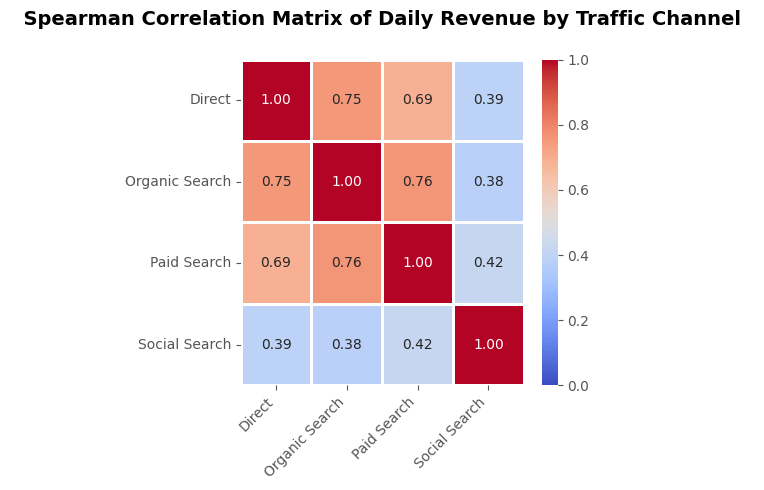

In [50]:
# Visualization of the Correlation Matrix (Heatmap)

plt.figure(figsize= (5, 5))

sns.heatmap(
    matrix_corr_channel,
    annot = True,
    cmap = "coolwarm",
    fmt = ".2f",
    linewidths= 0.75,
    vmin = 0,
    vmax= 1
)

plt.title("  Spearman Correlation Matrix of Daily Revenue by Traffic Channel  ", fontsize=14, fontweight='bold', pad= 25)

plt.xlabel("")
plt.ylabel("")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [51]:
# Calculate Spearman correlation and p-value for each  pair to assess statistical significance.

channels = pivot_table_channel_defined.columns

for i in range(len(channels)):
    for j in range(i + 1, len(channels)):
        channel1 = channels[i]
        channel2 = channels[j]
        rho, p_value = spearmanr(pivot_table_channel_defined[channel1], pivot_table_channel[channel2])
        print(f"  {channel1} vs {channel2}: rho={rho:.2f}, p-value={p_value:.7f} {'(Statistically significant)' if p_value < 0.05 else '(Not statistically significant)'}")


  Direct vs Organic Search: rho=0.75, p-value=0.0000000 (Statistically significant)
  Direct vs Paid Search: rho=0.69, p-value=0.0000000 (Statistically significant)
  Direct vs Social Search: rho=0.39, p-value=0.0001478 (Statistically significant)
  Organic Search vs Paid Search: rho=0.76, p-value=0.0000000 (Statistically significant)
  Organic Search vs Social Search: rho=0.38, p-value=0.0002144 (Statistically significant)
  Paid Search vs Social Search: rho=0.42, p-value=0.0000454 (Statistically significant)


Conclusion:

The Spearman correlation analysis indicates that all traffic channels exhibit statistically significant positive correlations in daily revenue.
The strongest relationships were observed between:

Organic Search and Paid Search (ρ = 0.764, p < 0.001)

Direct and Organic Search (ρ = 0.748, p < 0.001)

Direct and Paid Search (ρ = 0.691, p < 0.001)
These strong correlations suggest similar revenue trends across these acquisition channels, likely reflecting overlapping user behavior or marketing strategies.

Weaker but still significant correlations were found between Social Search and the other channels (ρ between 0.38 and 0.42), indicating a somewhat different revenue pattern that may reflect distinct audience behavior or campaign types.

## 6.4. Correlation Between Devices

In [52]:
# Create a pivot table to show a revenue by device by date

pivot_table_device = pd.pivot_table(
    df_sales,
    index = "order_date",
    columns = "device",
    values = "price",
    aggfunc= "sum"
).dropna()

pivot_table_device

device,Desktop,Mobile,Tablet
order_date,,,
2020-11-01,144445.0,99698.5,149.0
2020-11-02,206727.3,137269.5,11510.0
2020-11-03,304473.8,180602.8,13903.0
2020-11-04,212227.7,118324.4,8635.0
2020-11-05,249682.0,138256.0,3338.6
...,...,...,...
2021-01-23,174769.3,115462.2,374.0
2021-01-24,147218.2,93233.2,3367.0
2021-01-25,189441.7,107902.6,7745.0


In [53]:
# Test normality of device using Shapiro-Wilk test

columns_device = ["Desktop", "Mobile", "Tablet"]
shapiro_test(pivot_table_device, columns_device)

Distribution in Desktop - normality p-value: 0.0150
The distribution in Desktop is not normal.

Distribution in Mobile - normality p-value: 0.0014
The distribution in Mobile is not normal.

Distribution in Tablet - normality p-value: 0.0003
The distribution in Tablet is not normal.



All variables failed the Shapiro-Wilk normality test, with p-values of 0.0150, 0.0014, and 0.0003 respectively, all below the 0.05 threshold. This indicates that the distributions are not normal. Therefore, Spearman's rank correlation is the appropriate method to assess the relationships between them.

In [54]:
# Creating a Spearman correlation matrix

matrix_corr_device = pivot_table_device.corr( method = "spearman").round(2)
matrix_corr_device

device,Desktop,Mobile,Tablet
device,,,
Desktop,1.00,0.77,0.39
Mobile,0.77,1.00,0.40
Tablet,0.39,0.40,1.00


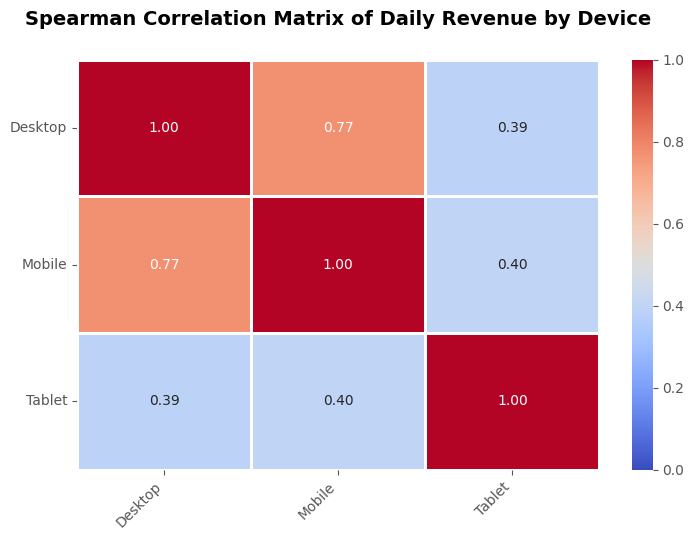

In [55]:
# Visualization of the Correlation Matrix (Heatmap)

plt.figure(figsize= (7.5, 5.5))

sns.heatmap(
    matrix_corr_device,
    annot = True,
    cmap = "coolwarm",
    fmt = ".2f",
    linewidths= 0.75,
    vmin = 0,
    vmax= 1
)

plt.title("Spearman Correlation Matrix of Daily Revenue by Device", fontsize=14, fontweight='bold', pad= 25)

plt.xlabel("")
plt.ylabel("")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [56]:
# Calculate Spearman correlation and p-value for each  pair to assess statistical significance.

devices = pivot_table_device.columns

for i in range(len(devices)):
    for j in range(i + 1, len(devices)):
        device1 = devices[i]
        device2 = devices[j]
        rho, p_value = spearmanr(pivot_table_device[device1], pivot_table_device[device2])
        print(f"  {device1} vs {device2}: rho={rho:.2f}, p-value={p_value:.7f} {'(Statistically significant)' if p_value < 0.05 else '(Not statistically significant)'}")


  Desktop vs Mobile: rho=0.77, p-value=0.0000000 (Statistically significant)
  Desktop vs Tablet: rho=0.39, p-value=0.0001706 (Statistically significant)
  Mobile vs Tablet: rho=0.40, p-value=0.0001061 (Statistically significant)


Conclusion:

The Spearman correlation analysis revealed statistically significant positive correlations between all device pairs in terms of daily revenue.
The strongest correlation was observed between Desktop and Mobile devices (ρ = 0.77, p < 0.001), indicating that revenue patterns on these platforms tend to move together.

Moderate correlations were also observed between Desktop and Tablet (ρ = 0.39, p < 0.001) and Mobile and Tablet (ρ = 0.40, p < 0.001).

These results suggest similar user purchasing behavior across device types, with some variation between mobile and tablet usage patterns.

## 6.5. Correlation Between Categories (Top-5)

In [57]:
# Create a pivot table to show a revenue by top-5 categories by date

top_5_categories = top10_categories_by_revenue .head(5).index.to_list()
top_5_categories_revenue_by_date = df_sales[df_sales['product_category'].isin(top_5_categories)]

pivot_table_categories = pd.pivot_table(
    top_5_categories_revenue_by_date,
    index = "order_date",
    columns = "product_category",
    values = "price",
    aggfunc = "sum"
    ).dropna()

pivot_table_categories

product_category,Beds,Bookcases & Shelving Units,Cabinets & Cupboards,Chairs,Sofas & Armchairs
order_date,,,,,
2020-11-01,14041.0,36701.0,13591.5,46006.0,75216.0
2020-11-02,79683.5,40979.0,21623.0,58834.0,79977.5
2020-11-03,66219.5,64360.1,33555.5,61204.0,175594.0
2020-11-04,48939.0,35719.8,19266.0,44113.0,86861.5
2020-11-05,23449.0,40998.8,29235.0,90388.4,137288.0
...,...,...,...,...,...
2021-01-23,37116.0,29862.7,26068.0,57493.0,76898.0
2021-01-24,23294.0,25396.0,23664.5,54288.0,57837.0
2021-01-25,47303.5,25919.6,33028.0,51424.2,84544.0


In [58]:
# Test normality of categories using Shapiro-Wilk test

shapiro_test(pivot_table_categories, top_5_categories)

Distribution in Sofas & Armchairs - normality p-value: 0.0122
The distribution in Sofas & Armchairs is not normal.

Distribution in Chairs - normality p-value: 0.0007
The distribution in Chairs is not normal.

Distribution in Beds - normality p-value: 0.0020
The distribution in Beds is not normal.

Distribution in Bookcases & Shelving Units - normality p-value: 0.0088
The distribution in Bookcases & Shelving Units is not normal.

Distribution in Cabinets & Cupboards - normality p-value: 0.0047
The distribution in Cabinets & Cupboards is not normal.



All variables failed the Shapiro-Wilk normality test, with p-values of 0.0122, 0.0007, 0.0020, 0.0088 and 0.0047 respectively, all below the 0.05 threshold. This indicates that the distributions are not normal. Therefore, Spearman's rank correlation is the appropriate method to assess the relationships between them.

In [59]:
# Creating a Spearman correlation matrix

matrix_corr_categories = pivot_table_categories.corr(method= "spearman").round(2)
matrix_corr_categories

product_category,Beds,Bookcases & Shelving Units,Cabinets & Cupboards,Chairs,Sofas & Armchairs
product_category,,,,,
Beds,1.00,0.54,0.44,0.53,0.52
Bookcases & Shelving Units,0.54,1.00,0.53,0.64,0.63
Cabinets & Cupboards,0.44,0.53,1.00,0.53,0.63
Chairs,0.53,0.64,0.53,1.00,0.58
Sofas & Armchairs,0.52,0.63,0.63,0.58,1.00


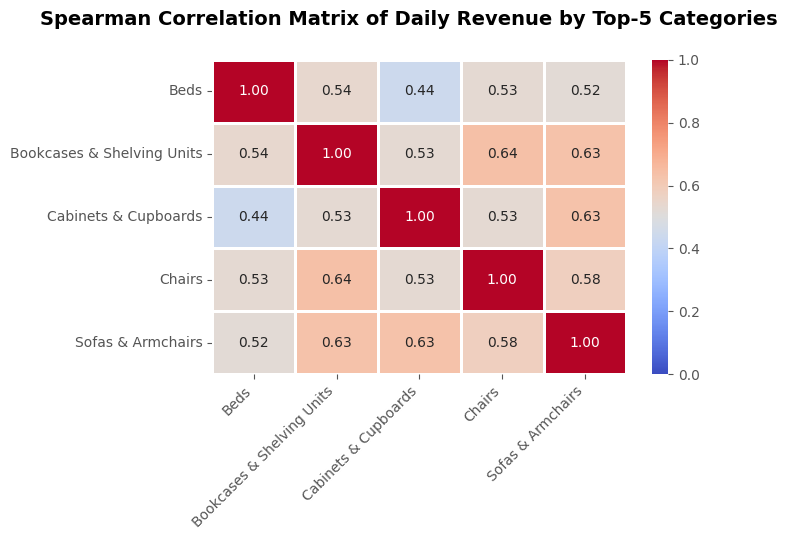

In [60]:
# Visualization of the Correlation Matrix (Heatmap)

plt.figure(figsize= (7.5, 5.5))
sns.heatmap(
    matrix_corr_categories,
    annot = True,
    cmap = "coolwarm",
    fmt = ".2f",
    linewidths= 0.75,
    vmin = 0,
    vmax= 1
)

plt.title("Spearman Correlation Matrix of Daily Revenue by Top-5 Categories   ", fontsize=14, fontweight='bold', pad= 25)

plt.xlabel("")
plt.ylabel("")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [61]:
# Calculate Spearman correlation and p-value for each  pair to assess statistical significance.

categories = pivot_table_categories.columns

for i in range(len(categories)):
    for j in range(i + 1, len(categories)):
        category1 = categories[i]
        category2 = categories[j]
        rho, p_value = spearmanr(pivot_table_categories[category1], pivot_table_categories[category2])
        print(f"  {category1} vs {category2}: rho={rho:.2f}, p-value={p_value:.7f} {'(Statistically significant)' if p_value < 0.05 else '(Not statistically significant)'}")


  Beds vs Bookcases & Shelving Units: rho=0.54, p-value=0.0000000 (Statistically significant)
  Beds vs Cabinets & Cupboards: rho=0.44, p-value=0.0000176 (Statistically significant)
  Beds vs Chairs: rho=0.53, p-value=0.0000001 (Statistically significant)
  Beds vs Sofas & Armchairs: rho=0.52, p-value=0.0000002 (Statistically significant)
  Bookcases & Shelving Units vs Cabinets & Cupboards: rho=0.53, p-value=0.0000001 (Statistically significant)
  Bookcases & Shelving Units vs Chairs: rho=0.64, p-value=0.0000000 (Statistically significant)
  Bookcases & Shelving Units vs Sofas & Armchairs: rho=0.63, p-value=0.0000000 (Statistically significant)
  Cabinets & Cupboards vs Chairs: rho=0.53, p-value=0.0000001 (Statistically significant)
  Cabinets & Cupboards vs Sofas & Armchairs: rho=0.63, p-value=0.0000000 (Statistically significant)
  Chairs vs Sofas & Armchairs: rho=0.58, p-value=0.0000000 (Statistically significant)


Conclusion:

The Spearman correlation analysis reveals statistically significant positive relationships in daily revenue among all top 5 product categories.

These strong associations suggest that sales in these categories tend to follow similar patterns, possibly due to shared customer preferences or complementary usage.

## 6.6. Correlation Between Operating System

In [62]:
# Create a pivot table to show a revenue by operating system by date

pivot_table_operating_system = pd.pivot_table(
    df_sales,
    index = "order_date",
    columns = "operating_system",
    values= "price",
    aggfunc = "sum"
).dropna()

pivot_table_operating_system


operating_system,<Other>,Android,Ios,Macintosh,Web,Windows
order_date,,,,,,
2020-11-01,11174.0,22876.0,28006.0,12658.0,142200.5,27378.0
2020-11-02,3485.0,29760.0,49178.5,24002.0,215286.8,33794.5
2020-11-03,10477.0,61197.9,55630.4,42585.5,248414.4,80674.4
2020-11-04,6904.0,18395.0,46229.0,26986.6,206917.4,33755.1
2020-11-05,10243.0,21888.6,48843.0,17035.0,242575.0,50692.0
...,...,...,...,...,...,...
2021-01-23,3512.0,22033.0,25201.0,25117.0,176337.0,38405.5
2021-01-24,13953.4,24163.6,24704.0,20063.0,124780.4,36154.0
2021-01-25,7600.0,18111.0,34203.0,24201.0,187699.1,33275.2


In [63]:
# Test normality of operating system using Shapiro-Wilk test

columns_operating_system = ["Android","Ios", "Macintosh", "Web", "Windows"]
shapiro_test(pivot_table_operating_system, columns_operating_system)

Distribution in Android - normality p-value: 0.0007
The distribution in Android is not normal.

Distribution in Ios - normality p-value: 0.0079
The distribution in Ios is not normal.

Distribution in Macintosh - normality p-value: 0.0422
The distribution in Macintosh is not normal.

Distribution in Web - normality p-value: 0.0032
The distribution in Web is not normal.

Distribution in Windows - normality p-value: 0.0043
The distribution in Windows is not normal.



In [64]:
pivot_table_operating_system_defined = pivot_table_operating_system.drop(columns= ["<Other>"])
matrix_corr_operating_system = pivot_table_operating_system_defined.corr(method= "spearman").round(2)
matrix_corr_operating_system

operating_system,Android,Ios,Macintosh,Web,Windows
operating_system,,,,,
Android,1.00,0.46,0.33,0.56,0.35
Ios,0.46,1.00,0.43,0.69,0.58
Macintosh,0.33,0.43,1.00,0.64,0.62
Web,0.56,0.69,0.64,1.00,0.70
Windows,0.35,0.58,0.62,0.70,1.00


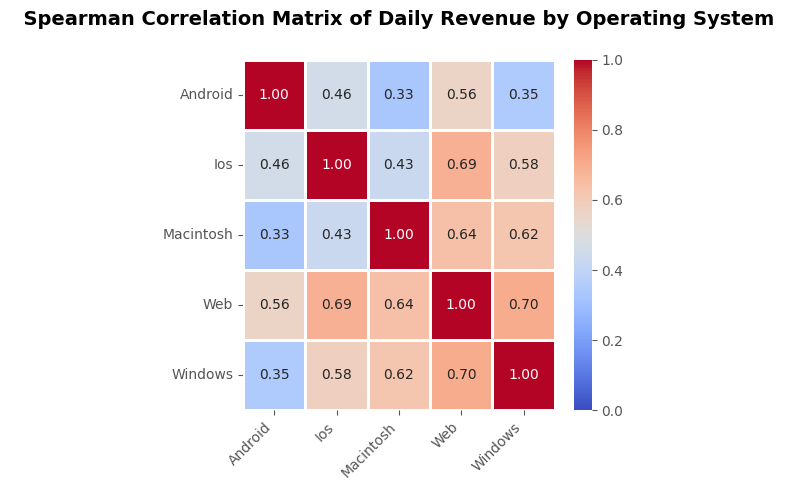

In [65]:
# Visualization of the Correlation Matrix (Heatmap)

plt.figure(figsize= (5, 5))
sns.heatmap(
    matrix_corr_operating_system,
    annot = True,
    cmap = "coolwarm",
    fmt = ".2f",
    linewidths= 0.75,
    vmin = 0,
    vmax= 1
)

plt.title("  Spearman Correlation Matrix of Daily Revenue by Operating System  ", fontsize=14, fontweight='bold', pad= 25)

plt.xlabel("")
plt.ylabel("")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [66]:
os = pivot_table_operating_system_defined.columns

for i in range(len(os)):
    for j in range(i + 1, len(os)):
        os1 = os[i]
        os2 = os[j]
        rho, p_value = spearmanr(pivot_table_operating_system_defined[os1], pivot_table_operating_system_defined[os2])
        print(f"  {os1} vs {os2}: rho={rho:.2f}, p-value={p_value:.7f} {'(Statistically significant)' if p_value < 0.05 else '(Not statistically significant)'}")


  Android vs Ios: rho=0.46, p-value=0.0000063 (Statistically significant)
  Android vs Macintosh: rho=0.33, p-value=0.0015916 (Statistically significant)
  Android vs Web: rho=0.56, p-value=0.0000000 (Statistically significant)
  Android vs Windows: rho=0.35, p-value=0.0007153 (Statistically significant)
  Ios vs Macintosh: rho=0.43, p-value=0.0000332 (Statistically significant)
  Ios vs Web: rho=0.69, p-value=0.0000000 (Statistically significant)
  Ios vs Windows: rho=0.58, p-value=0.0000000 (Statistically significant)
  Macintosh vs Web: rho=0.64, p-value=0.0000000 (Statistically significant)
  Macintosh vs Windows: rho=0.62, p-value=0.0000000 (Statistically significant)
  Web vs Windows: rho=0.70, p-value=0.0000000 (Statistically significant)


Conclusion:

All device pairs show statistically significant positive Spearman correlations in daily revenue.

The strongest associations were found between:

Web and Windows (ρ = 0.70)

Ios and Web (ρ = 0.69)

Macintosh and Web (ρ = 0.64)

These results suggest consistent revenue patterns across web-based and desktop platforms.

## 6.7. Summary: Correlation Analysis

To examine relationships in daily revenue across various dimensions, we first tested data normality using the **Shapiro–Wilk test**. Since the distributions were non-normal, we applied the **Spearman rank correlation** method.

The analysis revealed statistically significant **positive correlations** in all examined pairs, including:

- Session count vs. revenue  
- Revenue trends across continents  
- Marketing channels  
- Device types  
- Top product categories  
- Platforms (e.g., Web, iOS, Windows)

These results indicate strong alignment in user behavior and revenue patterns across segments, suggesting the influence of shared user preferences, synchronized marketing campaigns, and consistent cross-device experiences.

The findings support a unified revenue dynamic across platforms, products, and traffic sources in the e-commerce environment.


# **7. STATISTICAL ANALYSIS OF DIFFERENCES BETWEEN GROUPS**

## 7.1. Analysis of Differences (by Revenue) Between Registered and Unregistered Users

In [67]:
# Create a pivot table showing revenue by date by registred and unregistred users

df_sales["is_registred"] = df_sales['account_id'].notna()
df_sales.head()
df_sales_account = df_sales.groupby(["order_date", "is_registred"])["price"].sum().reset_index()

df_sales_account.head()
pivot_table_users = pd.pivot_table(
    df_sales_account,
    index= "order_date",
    columns= 'is_registred',
    values="price",
    aggfunc= "sum"

)

pivot_table_users.rename(columns ={False: "Revenue_unregistred", True: "Revenue_registred"}, inplace= True)
pivot_table_users

is_registred,Revenue_unregistred,Revenue_registred
order_date,,
2020-11-01,222745.5,21547.0
2020-11-02,310550.0,44956.8
2020-11-03,469829.1,29150.5
2020-11-04,318204.9,20982.2
2020-11-05,365942.0,25334.6
...,...,...
2021-01-23,274488.5,16117.0
2021-01-24,222904.4,20914.0
2021-01-25,270925.5,34163.8


In [68]:
# Test normality using Shapiro-Wilk test
# Compare two independent groups: use t-test if normal, Mann–Whitney U test if not

columns_users = ["Revenue_unregistred", "Revenue_registred"]
shapiro_test(pivot_table_users, columns_users)

Distribution in Revenue_unregistred - normality p-value: 0.0026
The distribution in Revenue_unregistred is not normal.

Distribution in Revenue_registred - normality p-value: 0.0073
The distribution in Revenue_registred is not normal.



Both distributions are not normal so we use Mann–Whitney U test (we have only two independent groups).

In [69]:
u_stat, p_value = mannwhitneyu(pivot_table_users['Revenue_unregistred'].dropna(), pivot_table_users["Revenue_registred"].dropna())
print(f"Mann Witney statistic: {u_stat:.3f}, p-value: {p:.7f}")

if p_value < 0.05:
   print("There is a statistically significant difference in daily revenue between registered and unregistered users (p < 0.05).")
else:
   print("No statistically significant difference in daily revenue between registered and unregistered users (p >= 0.05).")

Mann Witney statistic: 7744.000, p-value: 0.0000000
There is a statistically significant difference in daily revenue between registered and unregistered users (p < 0.05).


Conclusion:

There is a statistically significant difference in daily revenue between registered and unregistered users (p < 0.05).

This suggests that registration status affects purchasing behavior.

## 7.2. Analysis of Sessions by Traffic Channel

In [70]:
pivot_table_channel_session = pd.pivot_table(
    df_cleaned,
    index = "session_date",
    columns = "channel",
    values= "ga_session_id",
    aggfunc = "count"
)

pivot_table_channel_session

channel,Direct,Organic Search,Paid Search,Social Search,Undefined
session_date,,,,,
2020-11-01,608,920,706,214,128
2020-11-02,810,1242,970,315,262
2020-11-03,1216,1871,1367,392,327
2020-11-04,935,1425,1145,368,311
2020-11-05,845,1293,917,346,342
...,...,...,...,...,...
2021-01-27,984,1561,1192,359,339
2021-01-28,997,1379,1107,364,265
2021-01-29,878,1319,988,288,227


In [71]:
# Test normality of categories using Shapiro-Wilk test

shapiro_test(pivot_table_channel_session, columns_channel)


Distribution in Direct - normality p-value: 0.0343
The distribution in Direct is not normal.

Distribution in Organic Search - normality p-value: 0.0123
The distribution in Organic Search is not normal.

Distribution in Paid Search - normality p-value: 0.0108
The distribution in Paid Search is not normal.

Distribution in Social Search - normality p-value: 0.1413
The distribution in Social Search appears to be normal.



Three variables failed Shapiro-Wilk test, so we use Kruskal-Wallis to analyze statistical significance (we have four independent groups)

In [72]:
# Kruskal-Wallis test

h_stat, p = kruskal(*[pivot_table_channel_session[col] for col in pivot_table_channel_session.columns])
print(f"Kruskal H-statistic: {h_stat:.3f}, p-value: {p:.5f}")

if p < 0.05:
    print("There is a statistical significant diference between traffic channels")
else:
    print("There is no statistical significant diference between traffic channels")

Kruskal H-statistic: 368.981, p-value: 0.00000
There is a statistical significant diference between traffic channels


Conclusion:

A Kruskal–Wallis H-test was conducted to determine whether there are statistically significant differences in daily session counts across different traffic channels.

The result was significant:
H = 368.981, p < 0.00001, indicating that at least one traffic channel differs in session distribution compared to the others.

This suggests that user engagement varies by traffic source, and certain channels consistently generate more or fewer sessions than others.

## 7.3. Analysis of Organic Traffic Share: Europe vs. America

In [73]:
# Create a data to analize traffic channel - "Organic Search"

df_organic_traffic = df_cleaned[df_cleaned['channel'] == "Organic Search"]

pivot_table_organic_traffic = pd.pivot_table(
    df_organic_traffic,
    index = "session_date",
    columns = "continent",
    values = "ga_session_id",
    aggfunc= "count"
)

# Count percentage of session by continent per day

total_sessions_per_date = pivot_table_organic_traffic.sum(axis=1)
pivot_table_organic_traffic["total_session_per_date"]= total_sessions_per_date
pivot_table_organic_traffic_share = pivot_table_organic_traffic.div(total_sessions_per_date, axis=0)

organic_traffic_percentage = (pivot_table_organic_traffic.div(total_sessions_per_date, axis=0)) *100
organic_traffic_percentage.round(2).head(5)

continent,(Not Set),Africa,Americas,Asia,Europe,Oceania,total_session_per_date
session_date,,,,,,,
2020-11-01,<NA>,0.43,58.04,22.17,18.48,0.87,100.0
2020-11-02,0.08,1.21,52.66,26.33,18.36,1.37,100.0
2020-11-03,0.27,1.39,52.43,26.46,18.17,1.28,100.0
2020-11-04,0.14,1.61,56.07,22.53,18.74,0.91,100.0
2020-11-05,0.46,0.93,54.14,23.59,20.03,0.85,100.0


In [74]:
# Test normality using Shapiro-Wilk test

columns = ["Americas", "Europe"]
shapiro_test(organic_traffic_percentage, columns)

Distribution in Americas - normality p-value: 0.0143
The distribution in Americas is not normal.

Distribution in Europe - normality p-value: 0.0287
The distribution in Europe is not normal.



Both variables - "Americas", "Europe" failed Shapiro-Wilk test, so we use Mann Witney U test to analyze statistical significance (we have only two indepedent groups)

In [75]:
# Mann Witney U test

u_stat, p = mannwhitneyu(organic_traffic_percentage['Americas'], organic_traffic_percentage["Europe"])
print(f"Mann Witney statistic: {u_stat:.3f}, p-value: {p:.7f}")

if p < 0.05:
    print("There is a statistically significant difference in the median share of organic traffic between Americas and Europe.")
else:
    print("There is no statistically significant difference in the *median share* of organic traffic between Americas and Europe.")

Mann Witney statistic: 8464.000, p-value: 0.0000000
There is a statistically significant difference in the median share of organic traffic between Americas and Europe.


Conclusion:

The Mann-Whitney U test revealed a statistically significant difference in the median share of organic traffic between the Americas and Europe (U = 8464.000, p < 0.001).

## 7.4. Analysis of Differences in Revenue per Order by Day of Week

In [76]:
# Create a new column with name "day of week"

df_sales['day_of_week'] = df_sales['order_date'].dt.day_name()

# Calculate revenue by day of week and order from Monday to Sunday

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_sales_by_day_of_week = df_sales.groupby("day_of_week")["price"].mean().reindex(days_order)
df_sales_by_day_of_week.head(7)

,price
day_of_week,
Monday,934.359210
Tuesday,946.992174
Wednesday,973.734040
Thursday,984.433819
Friday,986.277191
Saturday,933.939554
Sunday,896.589623


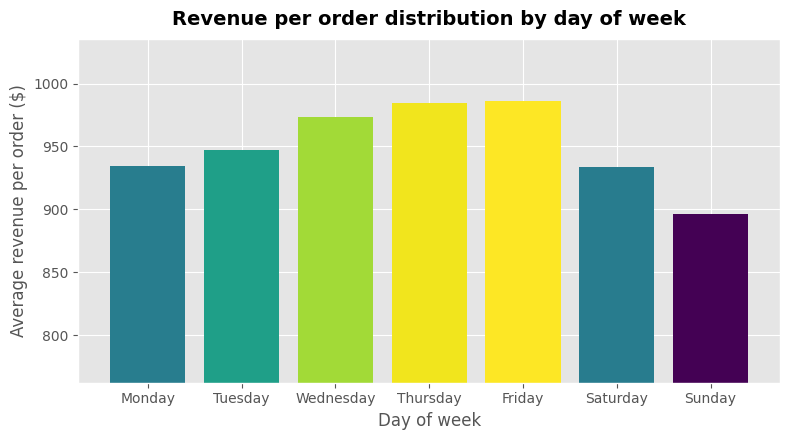

In [77]:
# Vizualisation of average sales per day of week

plt.figure(figsize = [8,4.5])

values = df_sales_by_day_of_week.values
norm = plt.Normalize(values.min(), values.max())

colors = cm.viridis(norm(values))

plt.bar(
    x= df_sales_by_day_of_week.index,
    height= df_sales_by_day_of_week.values,
    color = colors
    )

plt.title("Revenue per order distribution by day of week", fontsize =14, fontweight = "bold", pad = 10)

plt.xlabel("Day of week")
plt.ylabel("Average revenue per order ($)")

plt.ylim(df_sales_by_day_of_week.min() * 0.85, df_sales_by_day_of_week.max() * 1.05)

for bar in bars:
    yval = bar.get_height()

    plt.tight_layout()
plt.show()

In [78]:
# groups = [group["price"].values for name, group in df_sales.groupby("day_of_week")]

grouped = [df_sales[df_sales['day_of_week'] == day]['price'] for day in days_order]

# Kruskal-Wallis test

h_stat, p = kruskal(*grouped)
print(f"Kruskal H-statistic: {h_stat:.3f}, p-value: {p:.5f}")

if p < 0.05:
    print("There is a statistical significant diference between days of week")
else:
    print("There is no statistical significant diference between days of week")

Kruskal H-statistic: 10.028, p-value: 0.12348
There is no statistical significant diference between days of week


Conclusion:

Based on the non-parametric Kruskal-Wallis test, no statistically significant difference in revenue per order was found between different days of the week (H = 10.028, p = 0.12348)

## 7.5. Analysis of Differences (by Revenue) Between Verified and Unsubscribed Users

In [79]:
verified = df_account_sales[df_account_sales["is_verified"] == 1]
unsubscribed = df_account_sales[df_account_sales["is_unsubscribed"] == 1]
verified_by_date_revenue = verified.groupby('order_date')["price"].sum().reset_index()
unsubscribed_by_date_revenue = unsubscribed.groupby('order_date')['price'].sum().reset_index()
verified_by_date_revenue.rename(columns={"price": "verified_revenue"}, inplace=True)
unsubscribed_by_date_revenue.rename(columns={"price": "unsubscribed_revenue"}, inplace=True)

In [80]:
# Test normality using Shapiro-Wilk test

shapiro_test(verified_by_date_revenue, ["verified_revenue"])
shapiro_test(unsubscribed_by_date_revenue, ["unsubscribed_revenue"])

Distribution in verified_revenue - normality p-value: 0.1133
The distribution in verified_revenue appears to be normal.

Distribution in unsubscribed_revenue - normality p-value: 0.0000
The distribution in unsubscribed_revenue is not normal.



One of groups doesn't have normal distribution so we use Mann Witney U test to analyze

In [81]:
# Mann Witney U test

u_stat, p = mannwhitneyu(verified_by_date_revenue["verified_revenue"], unsubscribed_by_date_revenue["unsubscribed_revenue"], alternative= 'greater')
print(f"Mann Witney statistic: {u_stat:.3f}, p-value: {p:.7f}")

if p < 0.05:
    print("There is a statistically significant difference between groups.")
else:
    print("There is no statistically significant difference between groups")

Mann Witney statistic: 7531.000, p-value: 0.0000000
There is a statistically significant difference between groups.


Conclusion:

We tested whether verified users generate more revenue than users who unsubscribed from email communication. Since we hypothesized a specific direction (verified > unsubscribed), we applied a one-sided Mann–Whitney U test with alternative='greater'.

The result showed a statistically significant difference between the groups (U = 7531.000, p-value < 0.0001), supporting the hypothesis that verified users tend to bring higher daily revenue compared to unsubscribed users.

## 7.6. Summary: Statistical Analysis of Group Differences

Non-parametric statistical tests were conducted to explore group differences across user and traffic segments. The results indicate:

- **User status matters**: Registered and verified users consistently generate higher daily revenue than unregistered or unsubscribed users.
- **Traffic channels differ**: Significant variation exists in daily session counts across traffic sources, suggesting that some channels are more effective at driving engagement.
- **Regional behavior diverges**: Organic traffic shares differ between continents, highlighting geographic variation in acquisition strategies.
- **No weekly revenue pattern**: Revenue per order does not significantly differ by day of the week.

Overall, the results show that who the user is and where they come from makes a real difference. Some channels and regions clearly perform better, while weekly shopping habits seem stable — which is good news for planning and forecasting..



# 8. DATA IMPORT AND TABLEAU VISUALISATION

In [82]:
# Prepare df_cleaned to export file in csv format to Tableau

csv_file_name = 'ecommerce_analysis_data.csv'

# For visualisation in Tableau change some information in dataset

df_tableau = df_cleaned.copy()
df_tableau['is_verified'] = df_tableau['is_verified'].astype(object)
df_tableau['is_unsubscribed'] = df_tableau['is_unsubscribed'].astype(object)
df_tableau['is_verified'] = df_tableau['is_verified'].fillna('Not Registered')
df_tableau['is_unsubscribed'] = df_tableau['is_unsubscribed'].fillna('Not Registered')
df_tableau['is_verified'] = df_tableau['is_verified'].replace({0: 'Not Verified', 1: 'Verified'})
df_tableau['is_unsubscribed'] = df_tableau['is_unsubscribed'].replace({0: 'Subscribed', 1: 'Unsubscribed'})


In [83]:
df_tableau.to_csv(csv_file_name, index=False, encoding='utf-8-sig')
from google.colab import files
files.download(csv_file_name)

print(f"File '{csv_file_name}' saved and ready for download")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File 'ecommerce_analysis_data.csv' saved and ready for download


Tableau visualisation

https://public.tableau.com/shared/BHM5B5PNF?:display_count=n&:origin=viz_share_link